In [1]:
!pip install numpy
!pip install scipy
!pip install seaborn
!pip install pandas
!pip install matplotlib
!pip install sklearn
!pip install pymatgen
!pip install tensorflow

     |████████████████████████████████| 15.7 MB 4.7 MB/s            ��███████████████        | 11.7 MB 4.7 MB/s eta 0:00:01
     |████████████████████████████████| 38.1 MB 403 kB/s            
     |████████████████████████████████| 292 kB 4.6 MB/s            
     |████████████████████████████████| 11.2 MB 57.7 MB/s            
     |████████████████████████████████| 11.3 MB 53.0 MB/s            
     |████████████████████████████████| 3.1 MB 46.1 MB/s            
     |████████████████████████████████| 884 kB 39.2 MB/s            
     |████████████████████████████████| 1.1 MB 52.3 MB/s            
  Preparing metadata (setup.py) ... done
     |████████████████████████████████| 23.2 MB 4.5 MB/s            
     |████████████████████████████████| 306 kB 29.6 MB/s            
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1309 sha256=183ab1d24dca73188c9f0edebf470b05105d1aec79678161617346d6798811ed
  Stored in directory: /home/jovyan/.cache/pip/wheels/46/ef/

In [2]:
# Importing Libraries
import numpy as np
import scipy as sp
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_predict, cross_val_score
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import AdaBoostRegressor, AdaBoostClassifier, \
    GradientBoostingClassifier, GradientBoostingRegressor, \
    RandomForestClassifier, RandomForestRegressor
from scipy import linalg
from sklearn.discriminant_analysis import (LinearDiscriminantAnalysis as LDA, QuadraticDiscriminantAnalysis as QDA)
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from pymatgen.core import Element, Composition, periodic_table
from functools import partial
from pymatgen.ext.matproj import MPRester
mpr = MPRester("241iWwhTEOaNmC6V")
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn import svm, datasets
# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# import tensorflow.keras.layers as layers
# import tensorflow as tf
from pandas.plotting import scatter_matrix


In [3]:
#loading the testing and training data into the file to be manipulated in several forms

train = pd.read_csv("train.csv",index_col=False)
test = pd.read_csv("test.csv",index_col=False)



In [4]:
#Using pymatgen and the material ID we can query some of the data in our training set that we will use AND we will store this in a dataframe

base_data = mpr.query(criteria={"task_id": {"$in":train["material_id"].to_list()}}, properties=["material_id","energy",
        "energy_per_atom",
        "volume",
        "formation_energy_per_atom",
        "nsites",
        "pretty_formula",                                                                                  
        "nelements",
        "density",  "band_gap"])
base_data_DF = pd.DataFrame(base_data)



0 of 5619 done 0.0%
500 of 5619 done 8.9%
1000 of 5619 done 17.8%
1500 of 5619 done 26.7%
2000 of 5619 done 35.6%
2500 of 5619 done 44.5%
3000 of 5619 done 53.4%
3500 of 5619 done 62.3%
4000 of 5619 done 71.2%
4500 of 5619 done 80.1%
5000 of 5619 done 89.0%
5500 of 5619 done 97.9%
5619 of 5619 done 100.0%


In [5]:
#for the training data we will remove noble gases. Later on we will have to apply fixes to our code because the test set includes Xe 


#Making list of possible noble gases 
nobles = ["He","Ne", "Ar", "Kr", "Xe", "Rn", "Og"]
NoNobles_base_data_DF = base_data_DF

#Iterating through data and using pandas drop function to filter out materials containing noble gas elements 
for i in nobles:
    NoNobles_base_data_DF = NoNobles_base_data_DF.drop(NoNobles_base_data_DF[NoNobles_base_data_DF['pretty_formula'].str.contains(i)].index)
    
    

In [6]:
#this isn't the most efficient way to do this but why fix somthing that isnt technically broken
#I need to make an element properties dataframe similar to lab 2. How i did it in lab 2 was to get a list of unique elements in the NoNobles_base_data_DF and then making a dataframe that includes the data of each element


listA = [a for a in NoNobles_base_data_DF["pretty_formula"]]
listB = [Composition(a) for a in listA]
listC = [a.elements for a in listB]

editC = [item for sublist in listC for item in sublist]
unique_editC = set(editC)
unique_editC

UL_editC = [a for a in unique_editC]
indiv_ELproperties_train = [a.data for a in UL_editC]

peel = set(UL_editC)
sy_editC = [a.symbol for a in UL_editC]
sy_editC

indiv_ELproperties_train_DF = pd.DataFrame(indiv_ELproperties_train, index=sy_editC)

indiv_ELproperties_train_DF.head()



,Atomic mass,Atomic no,Atomic orbitals,Atomic radius,Atomic radius calculated,Boiling point,Brinell hardness,Bulk modulus,Coefficient of linear thermal expansion,Common oxidation states,...,NMR Quadrupole Moment,Metallic radius,iupac_ordering,IUPAC ordering,Ground level,Ionization energies,Electron affinity,Ionic radii,Ionic radii hs,Ionic radii ls
H,1.007940,1,{'1s': -0.233471},0.25,0.53,20.28 K,no data MN m<sup>-2</sup>,no data GPa,no data x10<sup>-6</sup>K<sup>-1</sup>,"[-1, 1]",...,{'H-2': 2.86},no data,92,92,2S1/2,[13.598434599702],0.754598,NaN,NaN,NaN
Li,6.941000,3,"{'1s': -1.878564, '2s': -0.10554}",1.45,1.67,1615 K,no data MN m<sup>-2</sup>,11 GPa,46 x10<sup>-6</sup>K<sup>-1</sup>,[1],...,"{'Li-6': -0.808, 'Li-7': -40.1}",1.52,11,11,2S1/2,"[5.391714996, 75.640097, 122.45435914]",0.618049,{'1': 0.9},NaN,NaN
Be,9.012182,4,"{'1s': -3.856411, '2s': -0.205744}",1.05,1.12,2742 K,600 MN m<sup>-2</sup>,130 GPa,11.3 x10<sup>-6</sup>K<sup>-1</sup>,[2],...,{'Be-9': 52.88},1.12,17,17,1S0,"[9.322699, 18.21115, 153.896205, 217.7185861]",-0.520000,{'2': 0.59},NaN,NaN
B,10.811000,5,"{'1s': -6.564347, '2p': -0.136603, '2s': -0.34...",0.85,0.87,4200 K,no data MN m<sup>-2</sup>,320 GPa,6 x10<sup>-6</sup>K<sup>-1</sup>,[3],...,"{'B-10': 84.59, 'B-11': 40.59}",no data,81,81,2P°1/2,"[8.298019, 25.15483, 37.93059, 259.3715, 340.2...",0.279723,{'3': 0.41},NaN,NaN
C,12.010700,6,"{'1s': -9.947718, '2p': -0.199186, '2s': -0.50...",0.70,0.67,4300 K,no data MN m<sup>-2</sup>,33 GPa,7.1 x10<sup>-6</sup>K<sup>-1</sup>,"[-4, 4]",...,{'C-11': 33.27},no data,86,86,3P0,"[11.260288, 24.383154, 47.88778, 64.49352, 392...",1.262114,{'4': 0.3},NaN,NaN


In [7]:
#Off top there are some properties that I don't want to use, either because there is significant lack of data for them, they are mostly words and not numbers or they are ranges, or they seem to be repeated
#there will be several droplists i will try to make this more ordered by numbering them all

droplist_1 = ['Ionic radii',
    'Ionic radii hs', 
     'Ionic radii ls',
     'iupac_ordering', 
     'IUPAC ordering', 
     'NMR Quadrupole Moment', 
     'Reflectivity',
     'Refractive index', 
     'Rigidity modulus', 
     'Shannon radii',
     'Superconduction temperature',
     'Mendeleev no',       
     'Mineral hardness',
     'Molar volume',
     'Name',
     'Oxidation states',
     'ICSD oxidation states',
     'Brinell hardness',
     'Atomic orbitals', 
     'Coefficient of linear thermal expansion',
     'Atomic orbitals',
     'Electronic structure',
     'Electrical resistivity',
     'Ground level'
           ]


indiv_ELproperties_train_DF = indiv_ELproperties_train_DF.drop(columns=droplist_1)


indiv_ELproperties_train_DF.head()


,Atomic mass,Atomic no,Atomic radius,Atomic radius calculated,Boiling point,Bulk modulus,Common oxidation states,Critical temperature,Density of solid,Liquid range,...,Poissons ratio,Thermal conductivity,Van der waals radius,Velocity of sound,Vickers hardness,X,Youngs modulus,Metallic radius,Ionization energies,Electron affinity
H,1.007940,1,0.25,0.53,20.28 K,no data GPa,"[-1, 1]",33 K,no data kg m<sup>-3</sup>,6.27 K,...,no data,0.1805 W m<sup>-1</sup> K<sup>-1</sup>,1.10,1270 m s<sup>-1</sup>,no data MN m<sup>-2</sup>,2.20,no data GPa,no data,[13.598434599702],0.754598
Li,6.941000,3,1.45,1.67,1615 K,11 GPa,[1],3223 K,535 kg m<sup>-3</sup>,1161.31 K,...,no data,85 W m<sup>-1</sup> K<sup>-1</sup>,1.82,6000 m s<sup>-1</sup>,no data MN m<sup>-2</sup>,0.98,4.9 GPa,1.52,"[5.391714996, 75.640097, 122.45435914]",0.618049
Be,9.012182,4,1.05,1.12,2742 K,130 GPa,[2],no data K,1848 kg m<sup>-3</sup>,1182 K,...,0.032,190 W m<sup>-1</sup> K<sup>-1</sup>,1.53,13000 m s<sup>-1</sup>,1670 MN m<sup>-2</sup>,1.57,287 GPa,1.12,"[9.322699, 18.21115, 153.896205, 217.7185861]",-0.520000
B,10.811000,5,0.85,0.87,4200 K,320 GPa,[3],no data K,2460 kg m<sup>-3</sup>,1851 K,...,no data,27 W m<sup>-1</sup> K<sup>-1</sup>,1.92,16200 m s<sup>-1</sup>,49000 MN m<sup>-2</sup>,2.04,no data GPa,no data,"[8.298019, 25.15483, 37.93059, 259.3715, 340.2...",0.279723
C,12.010700,6,0.70,0.67,4300 K,33 GPa,"[-4, 4]",no data K,2267 kg m<sup>-3</sup>,500 K,...,no data,140 W m<sup>-1</sup> K<sup>-1</sup>,1.70,18350 m s<sup>-1</sup>,no data MN m<sup>-2</sup>,2.55,no data GPa,no data,"[11.260288, 24.383154, 47.88778, 64.49352, 392...",1.262114


So initially we only queried and used the data available on pymatgen without building any features like we did in lab 2 that model performance wasn't good. it was my first attempt and it had a value of 173 when I submitted it to kaggle. We talked to the TA and he said to build the features out. Now the .data command took us forever to find. I don't know why. But once we found that and had the values at least we could start to do data cleaning of the data we had enough of. But I did want to say this part took us SO SO long. It was honestly very frustrating and in the future i think it might be worth it to provide more examples of the data cleaning so that we can focus more on choosing features and models and not data cleaning.

In [8]:
#Data cleaning lines. These should all work. But you can't run them twice without error. You are saving the new clean data into the dataframe so it wont be able to find anything since it is very column specific and once ran once
##there is nothing to fix. that being said the coerce to apply numeric is in a different box because i dont want to risk it making them numeric before i do a bunch of string operations. 

indiv_ELproperties_train_DF['Boiling point'] = [(a.replace('K', '', 1)) for a in indiv_ELproperties_train_DF['Boiling point']]
indiv_ELproperties_train_DF['Bulk modulus'] = indiv_ELproperties_train_DF["Bulk modulus"].str.replace("GPa", "")
indiv_ELproperties_train_DF['Critical temperature'] = indiv_ELproperties_train_DF["Critical temperature"].str.replace("K", "")
indiv_ELproperties_train_DF['Density of solid'] = indiv_ELproperties_train_DF['Density of solid'].str.replace("no data", "NaN")
indiv_ELproperties_train_DF['Density of solid'] = indiv_ELproperties_train_DF["Density of solid"].str.replace("kg m<sup>-3</sup>", "")
indiv_ELproperties_train_DF['Liquid range'] = [(a.replace('K', '', 1)) for a in indiv_ELproperties_train_DF['Liquid range']]
indiv_ELproperties_train_DF['Poissons ratio'] = [(a.replace('no data', 'NaN', 1)) for a in indiv_ELproperties_train_DF['Poissons ratio']]
indiv_ELproperties_train_DF['Poissons ratio'] = indiv_ELproperties_train_DF['Poissons ratio'].str.replace("no data", "").astype(float)
indiv_ELproperties_train_DF['Thermal conductivity'] = [float(a.replace('W m<sup>-1</sup> K<sup>-1</sup>', "", 1)) for a in indiv_ELproperties_train_DF['Thermal conductivity']]
indiv_ELproperties_train_DF['Velocity of sound'] = indiv_ELproperties_train_DF['Velocity of sound'].str.replace("no data","NaN")
indiv_ELproperties_train_DF['Velocity of sound'] = [(a.replace('m s<sup>-1</sup>', '', 1)) for a in indiv_ELproperties_train_DF['Velocity of sound']]
indiv_ELproperties_train_DF['Vickers hardness'] = indiv_ELproperties_train_DF['Vickers hardness'].str.replace("no data", "NaN")
indiv_ELproperties_train_DF['Vickers hardness'] = [(a.replace('MN m<sup>-2</sup>', '', 1)) for a in indiv_ELproperties_train_DF['Vickers hardness']]
indiv_ELproperties_train_DF['Youngs modulus'] = indiv_ELproperties_train_DF['Youngs modulus'].str.replace("no data", "NaN")
indiv_ELproperties_train_DF['Youngs modulus'] = [(a.replace('GPa', '', 1)) for a in indiv_ELproperties_train_DF['Youngs modulus']]
indiv_ELproperties_train_DF['Bulk modulus'] = [(a.replace('no data', 'NaN', 1)) for a in indiv_ELproperties_train_DF['Bulk modulus']]
indiv_ELproperties_train_DF['Bulk modulus'] = [(a.replace('liquid', '', 1)) for a in indiv_ELproperties_train_DF['Bulk modulus']]
indiv_ELproperties_train_DF['Bulk modulus'] = indiv_ELproperties_train_DF['Bulk modulus'].str.replace(r"\(.*\)","",  regex=True).astype(float)
indiv_ELproperties_train_DF['Melting point'] = indiv_ELproperties_train_DF['Melting point'].str.replace("K", "")
indiv_ELproperties_train_DF['Melting point'] = indiv_ELproperties_train_DF['Melting point'].str.replace("white P", "")
indiv_ELproperties_train_DF['Melting point'] = indiv_ELproperties_train_DF['Melting point'].str.replace(r"\(.*\)","",  regex=True).astype(float)
indiv_ELproperties_train_DF['Metallic radius'] = indiv_ELproperties_train_DF['Metallic radius'].astype(str)
indiv_ELproperties_train_DF['Metallic radius'] = [(a.replace('no data', 'NaN', 1)) for a in indiv_ELproperties_train_DF['Metallic radius']]
indiv_ELproperties_train_DF['Metallic radius'] = indiv_ELproperties_train_DF['Metallic radius'].astype(float)
indiv_ELproperties_train_DF['Common oxidation states'] = [len(a) for a in indiv_ELproperties_train_DF['Common oxidation states']]
indiv_ELproperties_train_DF['First Ionization Energy'] = [a[0] for a in indiv_ELproperties_train_DF['Ionization energies']]

indiv_ELproperties_train_DF = indiv_ELproperties_train_DF.drop("Ionization energies", axis=1)

indiv_ELproperties_train_DF['Critical temperature'] = [(a.replace('no data', 'NaN', 1)) for a in indiv_ELproperties_train_DF['Critical temperature']]


In [9]:
indiv_ELproperties_train_DF = indiv_ELproperties_train_DF.apply(pd.to_numeric, errors='coerce')

In [10]:
#We need to compute the mean values of each column so that way we can place the means of each column in the spaces where we previously made sure there was NAN

#means
mean_col_vals = dict(indiv_ELproperties_train_DF.mean())
mean_col_vals


# Iterating through variable with averages to replace the NaN values in element_data
for key, value in mean_col_vals.items():
    indiv_ELproperties_train_DF.loc[indiv_ELproperties_train_DF[key].isnull(),key] = value



In [11]:
#We talked with the TA about extensive vs intensive properties and we needed to remove volume and energy as a result. though we could keep volume/atom. however we would have to build that first. as it is just easier to build
##that once we cleaned the other data. we did that here

#NoNobles_base_data_DF



NoNobles_basedata_DF_wcomp = NoNobles_base_data_DF
NoNobles_basedata_DF_wcomp['Composition'] = [Composition(c) for c in NoNobles_basedata_DF_wcomp["pretty_formula"]]
NoNobles_basedata_DF_wcomp['num_atoms'] = [c.num_atoms for c in NoNobles_basedata_DF_wcomp['Composition']]
NoNobles_basedata_DF_wcomp['volume_per_atom'] = NoNobles_basedata_DF_wcomp['volume']/NoNobles_basedata_DF_wcomp['num_atoms']



NoNobles_basedata_DF_wcomp
#this should be a dataframe of all the MPIDS with the relevant compositions which is necessary because we are about to start making features for the indiv_ELproperties_train_DF



,material_id,energy,energy_per_atom,volume,formation_energy_per_atom,nsites,pretty_formula,nelements,density,band_gap,Composition,num_atoms,volume_per_atom
0,mp-1001034,-52.019078,-3.715648,376.145863,-0.703661,14,Mg(InSe2)2,3,5.030727,0.7432,"(Mg, In, Se)",7.0,53.735123
1,mp-1001780,-22.364406,-5.591101,78.515319,-1.699567,4,LuCuS2,3,6.400668,1.5031,"(Lu, Cu, S)",4.0,19.628830
2,mp-1001786,-23.600913,-5.900228,71.701237,-2.103385,4,LiScS2,3,2.687084,1.5296,"(Li, Sc, S)",4.0,17.925309
3,mp-1002124,-19.780759,-9.890380,32.055765,-0.298402,2,HfC,2,9.868236,0.5774,"(Hf, C)",2.0,16.027883
4,mp-1004528,-95.454964,-5.614998,324.979430,-3.162482,17,CsB3PbF12,4,3.068458,6.3125,"(Cs, B, Pb, F)",17.0,19.116437
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5614,mvc-6916,-99.385289,-7.098949,156.686110,-2.307339,14,MgMn2O4,3,4.200544,0.0516,"(Mg, Mn, O)",7.0,22.383730
5615,mvc-6928,-91.603914,-6.543137,173.941832,-2.192463,14,Ca(FeO2)2,3,4.119621,1.7463,"(Ca, Fe, O)",7.0,24.848833
5616,mvc-6946,-36.735653,-6.122609,97.529160,-1.961400,6,SnO2,2,5.131960,2.1009,"(Sn, O)",3.0,32.509720
5617,mvc-7040,-145.212422,-8.067357,418.920727,-1.999722,18,Re2O7,2,3.840256,3.4689,"(Re, O)",9.0,46.546747


In [12]:
#this was the best way i figured out to make the additional properties. this is how i did it in lab 2. radius mean function was removed beceause it is never added to a dataframe and is just a tester to make sure they work


indiv_ELproperties_train_DF_dict = indiv_ELproperties_train_DF.to_dict()

#my functions
def propertymean(property, composition):
    sumofproperty = 0
    totalnumatoms = 0
    for element, number in composition.items():
        sumofproperty += (number*indiv_ELproperties_train_DF_dict[property][str(element)])
        totalnumatoms += number
    return sumofproperty/totalnumatoms

def maxofproperty(property, composition):
    propmax = None
    for element, number in composition.items():
        propertyvalue = indiv_ELproperties_train_DF_dict[property][str(element)]
        if propmax:
            propmax = propertyvalue if propertyvalue > propmax else propmax
        else:
            propmax = propertyvalue
    return propmax

def minofproperty(property, composition):
    propmin = None
    for element, number in composition.items():
        propertyvalue = indiv_ELproperties_train_DF_dict[property][str(element)]
        if propmin:
            propmin = propertyvalue if propertyvalue < propmin else propmin
        else:
            propmin = propertyvalue
    return propmin



#assigning the values of those functions to a dataframe

avg_properties_df = pd.DataFrame()

for property in indiv_ELproperties_train_DF.columns:
    individualpropertymean = partial(propertymean, property)
    averages = NoNobles_basedata_DF_wcomp['Composition'].apply(individualpropertymean)
    avg_properties_df[("average_" + property)] = averages
    
avg_properties_df.head()
print("Average properties Dimension: ", avg_properties_df.shape)

max_properties = pd.DataFrame()

for property in indiv_ELproperties_train_DF.columns:
    individualpropertymax = partial(maxofproperty, property)
    max = NoNobles_basedata_DF_wcomp['Composition'].apply(individualpropertymax)
    max_properties[("max_" + property)] = max
    
min_properties = pd.DataFrame()

for property in indiv_ELproperties_train_DF.columns:
    individualpropertymin = partial(minofproperty, property)
    min = NoNobles_basedata_DF_wcomp['Composition'].apply(individualpropertymin)
    min_properties[("min_" + property)] = min


Average properties Dimension:  (5614, 21)


In [13]:
#Now we need to take all theses dataframes we have made with the min/max/average properties and put them in a single matrix that the models will be performed on


ALL_Features_Matrix =  pd.concat([NoNobles_basedata_DF_wcomp, avg_properties_df, min_properties, max_properties], axis=1)

#ALL_Features_Matrix.columns


#this is the second droplist: this one is to get rid of some features that we needed before to create new features list, but that we cant use because we couldnt clean properly or we intensive properties
droplist_2 = ['volume','energy', 'pretty_formula', 'Composition', 'average_Common oxidation states', 'min_Common oxidation states','max_Common oxidation states']


model_matrix_1 = ALL_Features_Matrix.drop(columns=droplist_2)
model_matrix_1 
#model_matrix_1 is the feature matrix for the training data that we will later split


,material_id,energy_per_atom,formation_energy_per_atom,nsites,nelements,density,band_gap,num_atoms,volume_per_atom,average_Atomic mass,...,max_Poissons ratio,max_Thermal conductivity,max_Van der waals radius,max_Velocity of sound,max_Vickers hardness,max_X,max_Youngs modulus,max_Metallic radius,max_Electron affinity,max_First Ionization Energy
0,mp-1001034,-3.715648,-0.703661,14,3,5.030727,0.7432,7.0,53.735123,81.397286,...,0.330000,160.0,1.93,4602.000000,2108.307692,2.55,45.000000,1.670000,2.020605,9.752392
1,mp-1001780,-5.591101,-1.699567,4,3,6.400668,1.5031,4.0,19.628830,75.660750,...,0.340000,400.0,2.24,3723.001515,2108.307692,2.58,130.000000,1.735000,2.077105,10.360010
2,mp-1001786,-5.900228,-2.103385,4,3,2.687084,1.5296,4.0,17.925309,29.006728,...,0.294269,85.0,2.15,6000.000000,2108.307692,2.58,111.786885,1.641000,2.077105,10.360010
3,mp-1002124,-9.890380,-0.298402,2,2,9.868236,0.5774,2.0,16.027883,95.250350,...,0.370000,140.0,2.23,18350.000000,2108.307692,2.55,111.786885,1.622591,1.262114,11.260288
4,mp-1004528,-5.614998,-3.162482,17,4,3.068458,6.3125,17.0,19.116437,35.324664,...,0.440000,36.0,3.43,16200.000000,49000.000000,3.98,111.786885,2.719000,3.401190,17.422820
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5614,mvc-6916,-7.098949,-2.307339,14,3,4.200544,0.0516,7.0,22.383730,28.311241,...,0.294269,160.0,2.05,5150.000000,2108.307692,3.44,198.000000,1.622591,1.461105,13.618055
5615,mvc-6928,-6.543137,-2.192463,14,3,4.119621,1.7463,7.0,24.848833,30.823657,...,0.310000,200.0,2.31,4910.000000,2108.307692,3.44,211.000000,1.976000,1.461105,13.618055
5616,mvc-6946,-6.122609,-1.961400,6,2,5.131960,2.1009,3.0,32.509720,50.236267,...,0.360000,67.0,2.17,2500.000000,2108.307692,3.44,111.786885,1.622591,1.461105,13.618055
5617,mvc-7040,-8.067357,-1.999722,18,2,3.840256,3.4689,9.0,46.546747,53.823311,...,0.300000,48.0,2.16,4700.000000,2450.000000,3.44,463.000000,1.622591,1.461105,13.618055


In [14]:
#We removed the noble gases from the feature matrix. so we have to make sure that the part of the training set that is just MPIDS and dielectric polytotals has those removed as well
#While typing this i thought ... I removed noble gases from my training set. will that matter if one is included in my dataset.... something to think about for the next project. 

#list of the ids and a dataframe of them
MPIDs = list(NoNobles_base_data_DF["material_id"])
MPIDs = pd.DataFrame(MPIDs)

#setting a new dataframe equal to the dataframe that only includes the one in model_matrix_1 which does not include noble gases

NoNobles_training_set = train[train.index.isin(MPIDs.index)] 


#you have to make the material_id the index because the dataframe operations can't handle strings
NoNobles_training_set.set_index('material_id')

#have to do the same to the feature matrix // idk why this one needs the inplace true but that took longer to get right that should have.
model_matrix_1.set_index('material_id', inplace=True)


In [15]:
#just in case i want to check what is in the NoNobles_training_set dataframe
#NoNobles_training_set

In [16]:
#just in case i want to check what is in the NoNobles_training_set dataframe
#model_matrix_1

Here is where you either run your model or start to do feature selection. I think for simplicity i will do the feature selection here and then do droplists according to different features I would like to drop.
Ultimately I didnt really like any of my models so it really doesn't matter which I choose. I have no clue how people got better than 7ish... which ultimately stephanie and I achieved working together even though i only submitted my 8 on kaggle. so i will have the feature selection first and then just do the splits for each model that i ultimately worked with 


some other things we tried that didnt really improve the model accuracy was test size and random state.

With regards to feature selection.

i tried a heat map (too many properties to see so I would up just printing the correlations to the datafram and looking at them there)
i tried a scatter_matrix( never fully ran so I assume it was just too much data, so essentially same problem)

I like printing the correlations to a dataframe and coloring those to determine which ones are important(it was brought up that this is low tech and could lead to missing them, but the others seemed like more work than they offered in results. (also additionally I never exactly figured out how to apply two colors to the same map) (you can idnore the ones that are 1 obviously)



In [17]:
#Getting the correlations
model_matrix_1_corr = model_matrix_1.corr()

In [18]:
#how to make the positive correlatins red

def color_negative_red(val):
    color = 'red' if 0.85 < val and val < 1.00 else 'black'
    return 'color: %s' % color


model_matrix_1_corr.style.applymap(color_negative_red)


,energy_per_atom,formation_energy_per_atom,nsites,nelements,density,band_gap,num_atoms,volume_per_atom,average_Atomic mass,average_Atomic no,average_Atomic radius,average_Atomic radius calculated,average_Boiling point,average_Bulk modulus,average_Critical temperature,average_Density of solid,average_Liquid range,average_Melting point,average_Poissons ratio,average_Thermal conductivity,average_Van der waals radius,average_Velocity of sound,average_Vickers hardness,average_X,average_Youngs modulus,average_Metallic radius,average_Electron affinity,average_First Ionization Energy,min_Atomic mass,min_Atomic no,min_Atomic radius,min_Atomic radius calculated,min_Boiling point,min_Bulk modulus,min_Critical temperature,min_Density of solid,min_Liquid range,min_Melting point,min_Poissons ratio,min_Thermal conductivity,min_Van der waals radius,min_Velocity of sound,min_Vickers hardness,min_X,min_Youngs modulus,min_Metallic radius,min_Electron affinity,min_First Ionization Energy,max_Atomic mass,max_Atomic no,max_Atomic radius,max_Atomic radius calculated,max_Boiling point,max_Bulk modulus,max_Critical temperature,max_Density of solid,max_Liquid range,max_Melting point,max_Poissons ratio,max_Thermal conductivity,max_Van der waals radius,max_Velocity of sound,max_Vickers hardness,max_X,max_Youngs modulus,max_Metallic radius,max_Electron affinity,max_First Ionization Energy
energy_per_atom,1.000000,0.556058,-0.221071,-0.220244,-0.143316,-0.215349,-0.221879,0.232992,0.381177,0.387721,0.465714,0.422691,-0.215414,-0.583676,0.415037,-0.246381,-0.065004,-0.298528,0.174562,0.206979,0.363604,0.056653,-0.125426,-0.367979,-0.401285,0.211970,0.306772,-0.303192,0.386531,0.391077,0.410435,0.488794,0.236461,-0.356637,0.412104,-0.035656,0.209784,0.230867,0.145247,0.061609,0.296760,0.340997,0.109955,-0.011656,-0.141133,0.011020,0.081975,-0.047557,0.113782,0.114304,0.202677,0.094409,-0.544657,-0.326770,0.090342,-0.123440,-0.342284,-0.550687,0.078477,0.108038,0.175829,-0.274705,-0.143656,-0.372146,-0.274720,0.222237,0.353541,-0.303214
formation_energy_per_atom,0.556058,1.000000,-0.112296,-0.282231,0.045619,-0.518363,-0.236963,0.259601,0.381903,0.388881,0.382399,0.393313,0.288013,-0.267665,0.441604,-0.180905,0.254947,0.273870,0.205546,0.312618,0.305917,0.204594,0.000567,-0.568522,-0.173874,-0.033038,-0.262436,-0.494799,0.378321,0.388095,0.490748,0.635682,0.484545,-0.119012,0.543084,0.094176,0.430446,0.473768,0.131069,0.260273,0.380144,0.277391,0.086344,0.269499,0.065777,-0.031647,0.082565,0.210454,0.091297,0.089976,-0.103113,-0.141687,-0.198365,-0.071932,-0.109406,0.012432,-0.173495,-0.148792,0.062677,0.124765,-0.082192,-0.039396,-0.054522,-0.745436,-0.069759,-0.064523,-0.214035,-0.609800
nsites,-0.221071,-0.112296,1.000000,0.287108,-0.164438,0.139590,0.483258,0.304728,-0.263022,-0.267942,-0.248814,-0.230444,-0.146350,0.131518,-0.160137,0.015153,-0.155502,-0.112734,-0.100641,-0.125148,-0.232302,-0.115172,0.043002,0.118020,0.095059,-0.058684,-0.131326,0.150843,-0.214926,-0.221718,-0.239066,-0.222050,-0.207046,-0.008472,-0.228999,-0.109691,-0.189819,-0.190700,-0.041550,-0.076230,-0.233285,-0.224257,0.003430,-0.034464,-0.003550,-0.044429,-0.067010,0.025196,-0.128064,-0.129172,-0.087116,-0.073282,0.082446,0.089741,0.089535,-0.014854,0.017990,0.111421,-0.081109,-0.045891,-0.082026,0.104984,0.055564,0.151733,0.090472,-0.067273,-0.118677,0.142694
nelements,-0.220244,-0.282231,0.287108,1.000000,-0.061104,0.112458,0.556930,-0.284748,-0.214071,-0.219159,-0.174055,-0.152208,-0.135816,0.108415,-0.109695,0.023968,-0.121345,-0.128002,-0.039967,-0.060581,-0.163560,-0.101752,-0.008531,0.118193,0.048664,0.025366,-0.076350,0.111266,-0.298242,-0.307931,-0.305297,-0.294221,-0.254945,-0.252621,-0.261899,-0.320714,-0.212538,-0.285589,-0.088806,-0.178968,-0.298832,-0.312260,-0.164979,-0.348305,-0.270304,-0.186766,-0.255296,-0.317710,0.055760,0.059266,0.221538,0.229492,0.219683,0.180016,0.343086,0.080240,0.192687,0.229505,0.080060,0.180403,0.170609,0.230557,0.070420,0.275484,0.1332

In [19]:
#how to make the negative correlatins blue

def color_negative_blue(val):
    color = 'blue' if -1.00 < val and val < -0.85 else 'black'
    return 'color: %s' % color

model_matrix_1_corr.style.applymap(color_negative_blue)

,energy_per_atom,formation_energy_per_atom,nsites,nelements,density,band_gap,num_atoms,volume_per_atom,average_Atomic mass,average_Atomic no,average_Atomic radius,average_Atomic radius calculated,average_Boiling point,average_Bulk modulus,average_Critical temperature,average_Density of solid,average_Liquid range,average_Melting point,average_Poissons ratio,average_Thermal conductivity,average_Van der waals radius,average_Velocity of sound,average_Vickers hardness,average_X,average_Youngs modulus,average_Metallic radius,average_Electron affinity,average_First Ionization Energy,min_Atomic mass,min_Atomic no,min_Atomic radius,min_Atomic radius calculated,min_Boiling point,min_Bulk modulus,min_Critical temperature,min_Density of solid,min_Liquid range,min_Melting point,min_Poissons ratio,min_Thermal conductivity,min_Van der waals radius,min_Velocity of sound,min_Vickers hardness,min_X,min_Youngs modulus,min_Metallic radius,min_Electron affinity,min_First Ionization Energy,max_Atomic mass,max_Atomic no,max_Atomic radius,max_Atomic radius calculated,max_Boiling point,max_Bulk modulus,max_Critical temperature,max_Density of solid,max_Liquid range,max_Melting point,max_Poissons ratio,max_Thermal conductivity,max_Van der waals radius,max_Velocity of sound,max_Vickers hardness,max_X,max_Youngs modulus,max_Metallic radius,max_Electron affinity,max_First Ionization Energy
energy_per_atom,1.000000,0.556058,-0.221071,-0.220244,-0.143316,-0.215349,-0.221879,0.232992,0.381177,0.387721,0.465714,0.422691,-0.215414,-0.583676,0.415037,-0.246381,-0.065004,-0.298528,0.174562,0.206979,0.363604,0.056653,-0.125426,-0.367979,-0.401285,0.211970,0.306772,-0.303192,0.386531,0.391077,0.410435,0.488794,0.236461,-0.356637,0.412104,-0.035656,0.209784,0.230867,0.145247,0.061609,0.296760,0.340997,0.109955,-0.011656,-0.141133,0.011020,0.081975,-0.047557,0.113782,0.114304,0.202677,0.094409,-0.544657,-0.326770,0.090342,-0.123440,-0.342284,-0.550687,0.078477,0.108038,0.175829,-0.274705,-0.143656,-0.372146,-0.274720,0.222237,0.353541,-0.303214
formation_energy_per_atom,0.556058,1.000000,-0.112296,-0.282231,0.045619,-0.518363,-0.236963,0.259601,0.381903,0.388881,0.382399,0.393313,0.288013,-0.267665,0.441604,-0.180905,0.254947,0.273870,0.205546,0.312618,0.305917,0.204594,0.000567,-0.568522,-0.173874,-0.033038,-0.262436,-0.494799,0.378321,0.388095,0.490748,0.635682,0.484545,-0.119012,0.543084,0.094176,0.430446,0.473768,0.131069,0.260273,0.380144,0.277391,0.086344,0.269499,0.065777,-0.031647,0.082565,0.210454,0.091297,0.089976,-0.103113,-0.141687,-0.198365,-0.071932,-0.109406,0.012432,-0.173495,-0.148792,0.062677,0.124765,-0.082192,-0.039396,-0.054522,-0.745436,-0.069759,-0.064523,-0.214035,-0.609800
nsites,-0.221071,-0.112296,1.000000,0.287108,-0.164438,0.139590,0.483258,0.304728,-0.263022,-0.267942,-0.248814,-0.230444,-0.146350,0.131518,-0.160137,0.015153,-0.155502,-0.112734,-0.100641,-0.125148,-0.232302,-0.115172,0.043002,0.118020,0.095059,-0.058684,-0.131326,0.150843,-0.214926,-0.221718,-0.239066,-0.222050,-0.207046,-0.008472,-0.228999,-0.109691,-0.189819,-0.190700,-0.041550,-0.076230,-0.233285,-0.224257,0.003430,-0.034464,-0.003550,-0.044429,-0.067010,0.025196,-0.128064,-0.129172,-0.087116,-0.073282,0.082446,0.089741,0.089535,-0.014854,0.017990,0.111421,-0.081109,-0.045891,-0.082026,0.104984,0.055564,0.151733,0.090472,-0.067273,-0.118677,0.142694
nelements,-0.220244,-0.282231,0.287108,1.000000,-0.061104,0.112458,0.556930,-0.284748,-0.214071,-0.219159,-0.174055,-0.152208,-0.135816,0.108415,-0.109695,0.023968,-0.121345,-0.128002,-0.039967,-0.060581,-0.163560,-0.101752,-0.008531,0.118193,0.048664,0.025366,-0.076350,0.111266,-0.298242,-0.307931,-0.305297,-0.294221,-0.254945,-0.252621,-0.261899,-0.320714,-0.212538,-0.285589,-0.088806,-0.178968,-0.298832,-0.312260,-0.164979,-0.348305,-0.270304,-0.186766,-0.255296,-0.317710,0.055760,0.059266,0.221538,0.229492,0.219683,0.180016,0.343086,0.080240,0.192687,0.229505,0.080060,0.180403,0.170609,0.230557,0.070420,0.275484,0.1332

In [20]:
#need this block because you need to be able to see which ones are correlated without having to go through the dataframe which is kinda tedius

lookthru = model_matrix_1_corr.columns

pos_correlated_ones_dict = {}

for col in lookthru:
    var = model_matrix_1_corr[model_matrix_1_corr[col] > 0.85].index.tolist()
    if col in var:
        var.remove(col)
    if var == []:
        continue
    pos_correlated_ones_dict[col] = var
print(pos_correlated_ones_dict)


{'average_Atomic mass': ['average_Atomic no'], 'average_Atomic no': ['average_Atomic mass'], 'average_Atomic radius': ['average_Atomic radius calculated', 'average_Van der waals radius'], 'average_Atomic radius calculated': ['average_Atomic radius', 'average_Van der waals radius'], 'average_Boiling point': ['average_Liquid range', 'average_Melting point'], 'average_Liquid range': ['average_Boiling point'], 'average_Melting point': ['average_Boiling point'], 'average_Van der waals radius': ['average_Atomic radius', 'average_Atomic radius calculated'], 'average_X': ['average_First Ionization Energy'], 'average_Electron affinity': ['max_Electron affinity'], 'average_First Ionization Energy': ['average_X'], 'min_Atomic mass': ['min_Atomic no'], 'min_Atomic no': ['min_Atomic mass'], 'min_Atomic radius': ['min_Atomic radius calculated', 'min_Critical temperature', 'min_Van der waals radius'], 'min_Atomic radius calculated': ['min_Atomic radius', 'min_Critical temperature'], 'min_Boiling poin

this is the subset of correlated ones you might remove on the positive correlation side

{'average_Atomic mass': ['average_Atomic no'],  
'average_Atomic radius': ['average_Atomic radius calculated', 'average_Van der waals radius'], , 
'average_Boiling point': ['average_Liquid range', 'average_Melting point'], , 
'average_Melting point': ['average_Boiling point'], 
'average_X': ['average_First Ionization Energy'], 
'average_Electron affinity': ['max_Electron affinity'], 
 'min_Atomic mass': ['min_Atomic no'], 
 'min_Atomic radius': ['min_Atomic radius calculated', 'min_Critical temperature', 'min_Van der waals radius'], 
 'min_Liquid range': ['min_Boiling point'], 
 'min_Melting point': ['min_Boiling point'],
 'min_Van der waals radius': ['min_Atomic radius'], 
 'min_First Ionization Energy': ['min_X'], 
  'max_Atomic no': ['max_Atomic mass'], 
  'max_Atomic radius calculated': ['max_Atomic radius', 'max_Van der waals radius', 'max_Metallic radius'], 
  
  
  this is a subst of the correlated ones you might remove on the negative side
  
  average_Atomic radius': ['average_First Ionization Energy']
  

In [21]:
#need this block because you need to be able to see which ones are correlated without having to go through the dataframe which is kinda tedius

lookthru2 = model_matrix_1_corr.columns

neg_correlated_ones_dict = {}

for col in lookthru2:
    var2 = model_matrix_1_corr[model_matrix_1_corr[col] < -0.85].index.tolist()
    if col in var2:
        var2.remove(col)
    if var2 == []:
        continue
    neg_correlated_ones_dict[col] = var2
print(neg_correlated_ones_dict)


{'average_Atomic radius': ['average_First Ionization Energy'], 'average_Atomic radius calculated': ['average_First Ionization Energy'], 'average_First Ionization Energy': ['average_Atomic radius', 'average_Atomic radius calculated'], 'min_Atomic radius calculated': ['max_X', 'max_First Ionization Energy'], 'max_X': ['min_Atomic radius calculated'], 'max_First Ionization Energy': ['min_Atomic radius calculated']}


<AxesSubplot:>

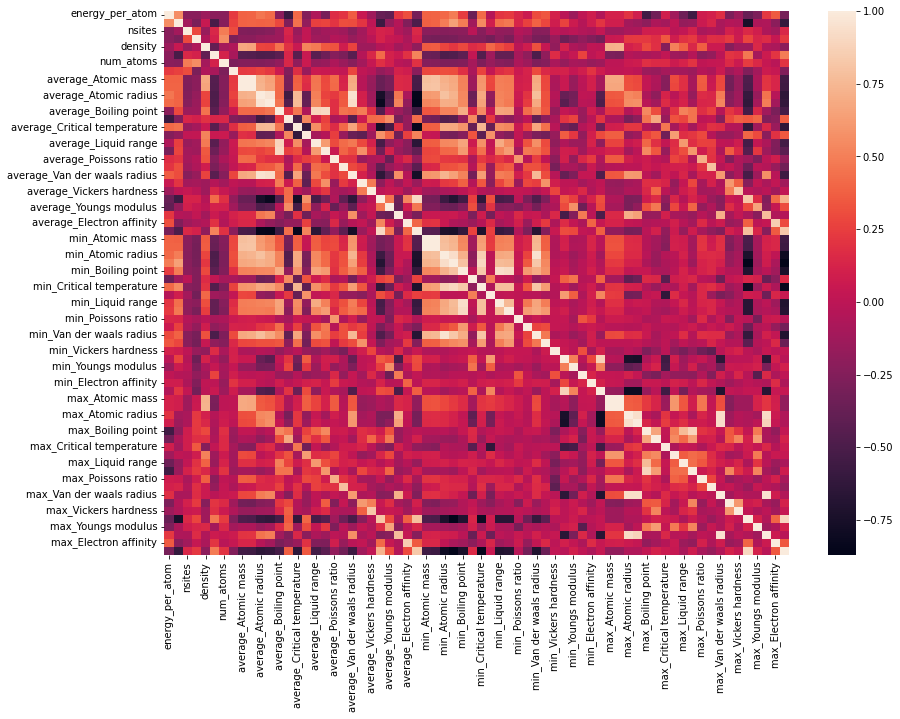

In [22]:
# I dont really believe you need to run this. But I'll leave it in to show you i tried it. 
# this is the heat map to display the correlations but there are just too many here to sus out and i didnt know a better way than the one above. 

fig, ax = plt.subplots()
## the size of A4 paper
fig.set_size_inches(14, 10)
sns.heatmap(model_matrix_1_corr)

In [23]:
#This one i tried but i really want to leave this hashtagged because it took soooooo long to run and never completed but again leaving it in so that you know i tried


# scatter_matrix(model_matrix_1, figsize=(20,20))



In [24]:
#Feature Selection: this is a list of the features that that I will drop from model_matrix_1 based on the feature selection

droplist_3 = ['max_Van der waals radius','min_Liquid range','max_Atomic radius', 'max_Atomic radius calculated', 'max_Metallic radius']



Test Data Querying

For the sake of saving time. And because we could submit our files to kaggle to check if we are right. Though Ideally we would have kept training the model until we got very close to accurately predicting the Ytest_train data by using the model appropriately. But ultimately we just trained a model. Predicted the data of the actual test set and determined how close we were on kaggle. so there is not a real point to doing the actual model priming here when its not something that we actually did. so we can just query the the test data now. try to predict the values and see how close we get


In [25]:
# Using material IDs provided in training data to get corresponding information from MPD
base_data_test = mpr.query(criteria={"task_id": {"$in":test["material_id"].to_list()}}, properties=["material_id","energy",
        "energy_per_atom",
        "volume",
        "formation_energy_per_atom",
        "nsites",
        "pretty_formula",                                                                                  
        "nelements",
        "density",  "band_gap"])
base_data_test_DF = pd.DataFrame(base_data_test)
#display(base_data_test_DF)

0 of 1400 done 0.0%
500 of 1400 done 35.7%
1000 of 1400 done 71.4%
1400 of 1400 done 100.0%


In [26]:
#Here is where for the Training data we removed the Noble Gases but here we will not be doing that so im not sure we actually need to call this anytype of filters



listA_X = [a for a in base_data_test_DF["pretty_formula"]]
listB_X = [Composition(a) for a in listA_X]
listC_X = [a.elements for a in listB_X]

editC_X = [item for sublist in listC_X for item in sublist]
unique_editC_X = set(editC_X)
unique_editC_X

UL_editC_X = [a for a in unique_editC_X]
indiv_ELproperties_test = [a.data for a in UL_editC_X]

peel=set(UL_editC_X)
sy_editC_X = [a.symbol for a in UL_editC_X]
sy_editC_X

#pd.set_option('display.max_rows', None)


indiv_ELproperties_test_DF = pd.DataFrame(indiv_ELproperties_test, index=sy_editC_X)

#Need droplist4 because you have to get rid of these two columns that exist because xenon is in the test group 
droplist_4 = droplist_1 + ['Max oxidation state', 'Min oxidation state']

#droplist_4

indiv_ELproperties_test_DF = indiv_ELproperties_test_DF.drop(columns=droplist_4)
#indiv_ELproperties_test_DF

In [27]:
#Data cleaning of the test data set

indiv_ELproperties_test_DF['Boiling point'] = [(a.replace('K', '', 1)) for a in indiv_ELproperties_test_DF['Boiling point']]
indiv_ELproperties_test_DF['Bulk modulus'] = indiv_ELproperties_test_DF["Bulk modulus"].str.replace("GPa", "")
indiv_ELproperties_test_DF['Critical temperature'] = indiv_ELproperties_test_DF["Critical temperature"].str.replace("K", "")
indiv_ELproperties_test_DF['Density of solid'] = indiv_ELproperties_test_DF['Density of solid'].str.replace("no data", "NaN")
indiv_ELproperties_test_DF['Density of solid'] = indiv_ELproperties_test_DF["Density of solid"].str.replace("kg m<sup>-3</sup>", "")
indiv_ELproperties_test_DF['Liquid range'] = [(a.replace('K', '', 1)) for a in indiv_ELproperties_test_DF['Liquid range']]
indiv_ELproperties_test_DF['Poissons ratio'] = [(a.replace('no data', 'NaN', 1)) for a in indiv_ELproperties_test_DF['Poissons ratio']]
indiv_ELproperties_test_DF['Poissons ratio'] = indiv_ELproperties_test_DF['Poissons ratio'].str.replace("no data", "").astype(float)
indiv_ELproperties_test_DF['Thermal conductivity'] = [float(a.replace('W m<sup>-1</sup> K<sup>-1</sup>', "", 1)) for a in indiv_ELproperties_test_DF['Thermal conductivity']]
indiv_ELproperties_test_DF['Velocity of sound'] = indiv_ELproperties_test_DF['Velocity of sound'].str.replace("no data","NaN")
indiv_ELproperties_test_DF['Velocity of sound'] = [(a.replace('m s<sup>-1</sup>', '', 1)) for a in indiv_ELproperties_test_DF['Velocity of sound']]
indiv_ELproperties_test_DF['Vickers hardness'] = indiv_ELproperties_test_DF['Vickers hardness'].str.replace("no data", "NaN", 1)
indiv_ELproperties_test_DF['Vickers hardness'] = [(a.replace('MN m<sup>-2</sup>', '', 1)) for a in indiv_ELproperties_test_DF['Vickers hardness']]
indiv_ELproperties_test_DF['Youngs modulus'] = indiv_ELproperties_test_DF['Youngs modulus'].str.replace("no data", "NaN", 1)
indiv_ELproperties_test_DF['Youngs modulus'] = [(a.replace('GPa', '', 1)) for a in indiv_ELproperties_test_DF['Youngs modulus']]
indiv_ELproperties_test_DF['Bulk modulus'] = [(a.replace('no data', 'NaN', 1)) for a in indiv_ELproperties_test_DF['Bulk modulus']]
indiv_ELproperties_test_DF['Bulk modulus'] = [(a.replace('liquid', '', 1)) for a in indiv_ELproperties_test_DF['Bulk modulus']]
indiv_ELproperties_test_DF['Bulk modulus'] = indiv_ELproperties_test_DF['Bulk modulus'].str.replace(r"\(.*\)","",  regex=True).astype(float)
indiv_ELproperties_test_DF['Melting point'] = indiv_ELproperties_test_DF['Melting point'].str.replace("K", "")
indiv_ELproperties_test_DF['Melting point'] = indiv_ELproperties_test_DF['Melting point'].str.replace("white P", "")
indiv_ELproperties_test_DF['Melting point'] = indiv_ELproperties_test_DF['Melting point'].str.replace(r"\(.*\)","",  regex=True).astype(float)
indiv_ELproperties_test_DF['Metallic radius'] = indiv_ELproperties_test_DF['Metallic radius'].astype(str)
indiv_ELproperties_test_DF['Metallic radius'] = [(a.replace('no data', 'NaN', 1)) for a in indiv_ELproperties_test_DF['Metallic radius']]
indiv_ELproperties_test_DF['Metallic radius'] = indiv_ELproperties_test_DF['Metallic radius'].astype(float)
#indiv_ELproperties_test_DF['Common oxidation states'] = [len(a) for a in indiv_ELproperties_test_DF['Common oxidation states']]
indiv_ELproperties_test_DF['First Ionization Energy'] = [a[0] for a in indiv_ELproperties_test_DF['Ionization energies']]

indiv_ELproperties_test_DF = indiv_ELproperties_test_DF.drop("Ionization energies", axis=1)

indiv_ELproperties_test_DF['Critical temperature'] = [(a.replace('no data', 'NaN', 1)) for a in indiv_ELproperties_test_DF['Critical temperature']]

#this code works but if for any reason there is an error you have to # out certain ones that cannot be run twice




In [28]:
#indiv_ELproperties_test_DF['First Ionization Energy'] = [a[0] for a in indiv_ELproperties_test_DF['Ionization energies']]

#indiv_ELproperties_test_DF = indiv_ELproperties_test_DF.drop("Ionization energies", axis=1)

indiv_ELproperties_test_DF['Critical temperature'] = [(a.replace('no data', 'NaN', 1)) for a in indiv_ELproperties_test_DF['Critical temperature']]

In [29]:
indiv_ELproperties_test_DF['Atomic radius'] = indiv_ELproperties_test_DF["Atomic radius"].astype(str)

In [30]:
indiv_ELproperties_test_DF['Atomic radius'] = indiv_ELproperties_test_DF["Atomic radius"].str.replace("no data", "NaN", 1)

In [31]:
indiv_ELproperties_test_DF

,Atomic mass,Atomic no,Atomic radius,Atomic radius calculated,Boiling point,Bulk modulus,Common oxidation states,Critical temperature,Density of solid,Liquid range,...,Poissons ratio,Thermal conductivity,Van der waals radius,Velocity of sound,Vickers hardness,X,Youngs modulus,Metallic radius,Electron affinity,First Ionization Energy
H,1.007940,1,0.25,0.53,20.28,NaN,"[-1, 1]",33,NaN,6.27,...,NaN,0.1805,1.10,1270,NaN,2.20,NaN,NaN,0.754598,13.598435
Li,6.941000,3,1.45,1.67,1615,11.0,[1],3223,535,1161.31,...,NaN,85.0000,1.82,6000,NaN,0.98,4.9,1.520,0.618049,5.391715
Be,9.012182,4,1.05,1.12,2742,130.0,[2],NaN,1848,1182,...,0.032,190.0000,1.53,13000,1670,1.57,287,1.120,-0.520000,9.322699
B,10.811000,5,0.85,0.87,4200,320.0,[3],NaN,2460,1851,...,NaN,27.0000,1.92,16200,49000,2.04,NaN,NaN,0.279723,8.298019
C,12.010700,6,0.7,0.67,4300,33.0,"[-4, 4]",NaN,2267,500,...,NaN,140.0000,1.70,18350,NaN,2.55,NaN,NaN,1.262114,11.260288
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Tl,204.383300,81,1.9,1.56,1746,43.0,"[1, 3]",NaN,11850,1169,...,0.450,46.0000,1.96,818,NaN,1.62,8,1.700,0.320053,6.108287
Pb,207.200000,82,1.8,1.54,2022,46.0,"[2, 4]",NaN,11340,1421.39,...,0.440,35.0000,2.02,1260,NaN,2.33,16,1.750,0.356721,7.416680
Bi,208.980400,83,1.6,1.43,1837,31.0,[3],NaN,9780,1292.6,...,0.330,8.0000,2.07,1790,NaN,2.02,32,1.820,0.942362,7.285516
Ac,227.000000,89,1.95,no data,3573,NaN,[3],NaN,10070,2250,...,NaN,12.0000,2.47,NaN,NaN,1.10,NaN,1.878,0.350000,5.380226


In [32]:
indiv_ELproperties_test_DF = indiv_ELproperties_test_DF.apply(pd.to_numeric, errors='coerce')

In [33]:
indiv_ELproperties_test_DF.dtypes

Atomic mass                 float64
Atomic no                     int64
Atomic radius               float64
Atomic radius calculated    float64
Boiling point               float64
Bulk modulus                float64
Common oxidation states     float64
Critical temperature        float64
Density of solid            float64
Liquid range                float64
Melting point               float64
Poissons ratio              float64
Thermal conductivity        float64
Van der waals radius        float64
Velocity of sound           float64
Vickers hardness            float64
X                           float64
Youngs modulus              float64
Metallic radius             float64
Electron affinity           float64
First Ionization Energy     float64
dtype: object

In [34]:
#We need to compute the mean values of each column so that way we can place the means of each column in the spaces where we previously made sure there was NAN

#means
mean_col_vals_test = dict(indiv_ELproperties_test_DF.mean())
mean_col_vals_test


# Iterating through variable with averages to replace the NaN values in element_data
for key, value in mean_col_vals_test.items():
    indiv_ELproperties_test_DF.loc[indiv_ELproperties_test_DF[key].isnull(),key] = value

In [35]:
indiv_ELproperties_test_DF.dtypes

Atomic mass                 float64
Atomic no                   float64
Atomic radius               float64
Atomic radius calculated    float64
Boiling point               float64
Bulk modulus                float64
Common oxidation states     float64
Critical temperature        float64
Density of solid            float64
Liquid range                float64
Melting point               float64
Poissons ratio              float64
Thermal conductivity        float64
Van der waals radius        float64
Velocity of sound           float64
Vickers hardness            float64
X                           float64
Youngs modulus              float64
Metallic radius             float64
Electron affinity           float64
First Ionization Energy     float64
dtype: object

In [36]:
#Adding some columns that we need 

base_data_test_DF_wcomp = base_data_test_DF
base_data_test_DF_wcomp['Composition'] = [Composition(c) for c in base_data_test_DF_wcomp["pretty_formula"]]
base_data_test_DF_wcomp['num_atoms'] = [c.num_atoms for c in base_data_test_DF_wcomp['Composition']]
base_data_test_DF_wcomp['volume_per_atom'] = base_data_test_DF_wcomp['volume']/base_data_test_DF_wcomp['num_atoms']
#base_data_test_DF_wcomp

In [37]:


indiv_ELproperties_test_DF_dict = indiv_ELproperties_test_DF.to_dict()


#my functions
def propertymean_X(property, composition):
    sumofproperty = 0
    totalnumatoms = 0
    for element, number in composition.items():
        sumofproperty += (number*indiv_ELproperties_test_DF_dict[property][str(element)])
        totalnumatoms += number
    return sumofproperty/totalnumatoms

def maxofproperty_X(property, composition):
    propmax = None
    for element, number in composition.items():
        propertyvalue = indiv_ELproperties_test_DF_dict[property][str(element)]
        if propmax:
            propmax = propertyvalue if propertyvalue > propmax else propmax
        else:
            propmax = propertyvalue
    return propmax

def minofproperty_X(property, composition):
    propmin = None
    for element, number in composition.items():
        propertyvalue = indiv_ELproperties_test_DF_dict[property][str(element)]
        if propmin:
            propmin = propertyvalue if propertyvalue < propmin else propmin
        else:
            propmin = propertyvalue
    return propmin


#assigning the values of those functions to a dataframe

avg_properties_df_X = pd.DataFrame()

for property in indiv_ELproperties_test_DF.columns:
    individualpropertymean = partial(propertymean_X, property)
    averages = base_data_test_DF_wcomp['Composition'].apply(individualpropertymean)
    avg_properties_df_X[("average_" + property)] = averages
    
avg_properties_df_X.head()
print("Average properties Dimension: ", avg_properties_df_X.shape)

max_properties_X = pd.DataFrame()

for property in indiv_ELproperties_test_DF.columns:
    individualpropertymax = partial(maxofproperty_X, property)
    max = base_data_test_DF_wcomp['Composition'].apply(individualpropertymax)
    max_properties_X[("max_" + property)] = max
    
min_properties_X = pd.DataFrame()

for property in indiv_ELproperties_test_DF.columns:
    individualpropertymin = partial(minofproperty_X, property)
    min = base_data_test_DF_wcomp['Composition'].apply(individualpropertymin)
    min_properties_X[("min_" + property)] = min



Average properties Dimension:  (1400, 21)


In [38]:
base_data_test_DF_wcomp

,material_id,energy,energy_per_atom,volume,formation_energy_per_atom,nsites,pretty_formula,nelements,density,band_gap,Composition,num_atoms,volume_per_atom
0,mp-1000,-8.646946,-4.323473,89.091084,-1.792337,2,BaTe,2,4.937886,1.8555,"(Ba, Te)",2.0,44.545542
1,mp-10044,-11.376365,-5.688183,27.982045,-0.019233,2,BAs,2,5.087631,1.2522,"(B, As)",2.0,13.991023
2,mp-10086,-42.877615,-7.146269,99.212472,-3.359731,6,YSF,3,4.685387,1.3137,"(Y, S, F)",3.0,33.070824
3,mp-1008858,-16.665812,-5.555271,80.958490,-0.944922,3,NdBiPd,3,9.427722,0.0900,"(Nd, Bi, Pd)",3.0,26.986163
4,mp-1008867,-11.760729,-3.920243,38.301187,-0.701211,3,NaCuO,3,4.445388,0.0017,"(Na, Cu, O)",3.0,12.767062
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1395,mvc-5908,-73.434572,-7.343457,120.736933,-2.771448,10,Ca2CrWO6,4,5.666228,1.6101,"(Ca, Cr, W, O)",10.0,12.073693
1396,mvc-5921,-64.816637,-6.481664,143.204106,-2.354943,10,Mg2SnWO6,4,5.185052,2.2892,"(Mg, Sn, W, O)",10.0,14.320411
1397,mvc-7386,-129.945458,-6.497273,386.834593,-1.936434,20,ZnMo2O7,3,3.170408,3.7020,"(Zn, Mo, O)",10.0,38.683459
1398,mvc-7701,-147.825353,-5.685591,330.380852,-1.957811,26,Zn2Sn3O8,3,6.181576,1.2507,"(Zn, Sn, O)",13.0,25.413912


In [39]:
#model_matrix_2 is our feature space but for the test data

ALL_Features_Matrix_test = pd.concat([base_data_test_DF_wcomp, avg_properties_df_X, min_properties_X, max_properties_X], axis=1)
ALL_Features_Matrix_test.columns

#droplist_2 hasnt changed from the one we used for our traindata
model_matrix_2 = ALL_Features_Matrix_test.drop(columns=droplist_2)
#model_matrix_2

In [40]:
#model_matrix_2

In [41]:
model_matrix_2.set_index('material_id',inplace=True)


In [42]:
# testfornulls = model_matrix_2.isnull().sum()
# testfornulls

In [43]:
#Train Test Split based on the training data

Xtrain_train, Xtest_train, Ytrain_train, Ytest_train = train_test_split(model_matrix_1, NoNobles_training_set,test_size=0.1, random_state=120)

In [44]:
NoNobles_training_set

,material_id,dielectric_poly_total
0,mp-555903,8.337936
1,mp-752658,14.735277
2,mp-3439,17.195305
3,mp-16135,21.593507
4,mp-36447,9.507068
...,...,...
5609,mp-754117,13.378949
5610,mp-1539137,16.908907
5611,mp-1079559,11.776195
5612,mp-555908,6.241000


In [45]:
#Normalizing Data

# In some cases not normallizing the data provided better results. Is it always required to normalize data??

# Computing mean and standard devaitaion for train X and normalizing
mean_Xtrain = Xtrain_train.apply(np.mean, axis=0)
std_Xtrain = Xtrain_train.apply(np.std, axis=0)
norm_Xtrain = (Xtrain_train - mean_Xtrain) / std_Xtrain

# Computing mean and standard devaitaion for test X and normalizing 
mean_Xtest = Xtest_train.apply(np.mean, axis=0)
std_Xtest = Xtest_train.apply(np.std, axis=0)
norm_Xtest = (Xtest_train - mean_Xtest) / std_Xtest




In [46]:
#Normalizing Data

# In some cases not normallizing the data provided better results. Is it always required to normalize data??

# Computing mean and standard devaitaion for train X and normalizing
mean_Xtrain = Xtrain_train.apply(np.mean, axis=0)
std_Xtrain = Xtrain_train.apply(np.std, axis=0)
norm_Xtrain = (Xtrain_train - mean_Xtrain) / std_Xtrain

# Computing mean and standard devaitaion for test X and normalizing 
mean_Xtest = Xtest_train.apply(np.mean, axis=0)
std_Xtest = Xtest_train.apply(np.std, axis=0)
norm_Xtest = (Xtest_train - mean_Xtest) / std_Xtestnorm_Xtrain

,energy_per_atom,formation_energy_per_atom,nsites,nelements,density,band_gap,num_atoms,volume_per_atom,average_Atomic mass,average_Atomic no,...,max_Poissons ratio,max_Thermal conductivity,max_Van der waals radius,max_Velocity of sound,max_Vickers hardness,max_X,max_Youngs modulus,max_Metallic radius,max_Electron affinity,max_First Ionization Energy
material_id,,,,,,,,,,,,,,,,,,,,,
mp-1006888,-0.283341,-0.504828,-0.979050,-0.230602,-0.677164,-0.081446,-0.758915,-0.416332,-0.068422,0.038124,...,-0.764567,-0.304014,0.895799,-0.454339,-0.216357,-1.028875,-0.441630,1.221881,0.026247,-1.146550
mp-1226281,0.457349,1.475402,-0.519910,1.114666,0.248370,-1.053962,0.403737,-0.445616,0.629809,0.680178,...,0.974842,2.773096,-0.592403,0.123545,-0.216357,-1.082656,1.609498,-0.837712,-0.035170,-1.094270
mp-555229,-0.165562,0.705672,0.092276,1.114666,-1.705005,1.525015,0.209962,-0.568509,-1.399356,-1.464461,...,-0.764567,0.068969,-1.545782,3.358341,-0.216357,0.512857,-0.441630,-0.837712,-0.643370,0.576115
mp-961675,-0.929731,0.678109,-1.055573,-0.230602,0.394089,-1.062567,-0.952690,-0.640757,-0.170906,-0.055509,...,-0.403257,-0.387935,-0.499390,-0.129296,-0.216357,-1.728032,0.640441,-0.787719,-0.973770,-1.094270
mp-1190488,-0.949741,-1.397281,0.551416,-0.230602,-0.318268,0.343773,0.791287,-0.439850,-0.728227,-0.724315,...,0.515475,0.954804,-0.429631,-0.095410,-0.216357,0.512857,-0.441630,-0.837712,-0.643370,0.198050
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
mp-1008223,0.552738,-0.055449,-1.132097,-1.575870,-0.836858,0.399405,-1.146465,-0.222500,0.304168,0.399280,...,0.056109,0.628444,-0.127340,-0.431662,-0.216357,-1.082656,-1.567538,0.122032,-0.035170,-1.397314
mp-560641,-0.059665,-2.217536,1.469696,-0.230602,0.305568,2.086416,5.441893,-0.518637,0.343344,0.301188,...,-0.764567,-1.068629,0.733026,-0.454339,-0.216357,1.480920,-0.441630,0.828108,1.695532,1.768281
mp-1210797,-0.325390,-0.825919,-0.060770,1.114666,-0.560311,0.765525,0.016186,-0.494726,-0.917721,-0.945022,...,-0.764567,0.255461,-0.592403,0.139185,-0.216357,0.512857,-0.441630,-0.837712,-0.643370,0.198050


Now we can do out models and provide results

linear model 1 is on on all the features with normalized data

In [47]:
linear_model_1 = LinearRegression()

linear_model_1.fit(norm_Xtrain, Ytrain_train['dielectric_poly_total'])
#linear_model_1_predictions_traintest = linear_model_1.predict(norm_Xtrain)
linear_model_1_predictions_test = linear_model_1.predict(model_matrix_2)

linear_model_1_score = -cross_val_score(linear_model_1, norm_Xtrain, Ytrain_train['dielectric_poly_total'], cv=5, scoring='neg_mean_absolute_error')



DF_linear_model_1 = pd.DataFrame(linear_model_1_predictions_test)
linear_model_1_list =[test, DF_linear_model_1]

subs =  pd.concat(linear_model_1_list, axis=1)
submissions = subs.rename(columns={0:'dielectric_poly_total'})
submissions.to_csv("linreg-1-attempt-1.csv", index=False)


In [48]:
np.mean(linear_model_1_score)

8.89317755308439

In [49]:
model_matrix_1

,energy_per_atom,formation_energy_per_atom,nsites,nelements,density,band_gap,num_atoms,volume_per_atom,average_Atomic mass,average_Atomic no,...,max_Poissons ratio,max_Thermal conductivity,max_Van der waals radius,max_Velocity of sound,max_Vickers hardness,max_X,max_Youngs modulus,max_Metallic radius,max_Electron affinity,max_First Ionization Energy
material_id,,,,,,,,,,,,,,,,,,,,,
mp-1001034,-3.715648,-0.703661,14,3,5.030727,0.7432,7.0,53.735123,81.397286,35.142857,...,0.330000,160.0,1.93,4602.000000,2108.307692,2.55,45.000000,1.670000,2.020605,9.752392
mp-1001780,-5.591101,-1.699567,4,3,6.400668,1.5031,4.0,19.628830,75.660750,33.000000,...,0.340000,400.0,2.24,3723.001515,2108.307692,2.58,130.000000,1.735000,2.077105,10.360010
mp-1001786,-5.900228,-2.103385,4,3,2.687084,1.5296,4.0,17.925309,29.006728,14.000000,...,0.294269,85.0,2.15,6000.000000,2108.307692,2.58,111.786885,1.641000,2.077105,10.360010
mp-1002124,-9.890380,-0.298402,2,2,9.868236,0.5774,2.0,16.027883,95.250350,39.000000,...,0.370000,140.0,2.23,18350.000000,2108.307692,2.55,111.786885,1.622591,1.262114,11.260288
mp-1004528,-5.614998,-3.162482,17,4,3.068458,6.3125,17.0,19.116437,35.324664,15.294118,...,0.440000,36.0,3.43,16200.000000,49000.000000,3.98,111.786885,2.719000,3.401190,17.422820
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
mvc-6916,-7.098949,-2.307339,14,3,4.200544,0.0516,7.0,22.383730,28.311241,13.428571,...,0.294269,160.0,2.05,5150.000000,2108.307692,3.44,198.000000,1.622591,1.461105,13.618055
mvc-6928,-6.543137,-2.192463,14,3,4.119621,1.7463,7.0,24.848833,30.823657,14.857143,...,0.310000,200.0,2.31,4910.000000,2108.307692,3.44,211.000000,1.976000,1.461105,13.618055
mvc-6946,-6.122609,-1.961400,6,2,5.131960,2.1009,3.0,32.509720,50.236267,22.000000,...,0.360000,67.0,2.17,2500.000000,2108.307692,3.44,111.786885,1.622591,1.461105,13.618055


linear model 2 is on on all the features with non normalized data

In [50]:
linear_model_2 = LinearRegression()

linear_model_2.fit(Xtrain_train, Ytrain_train['dielectric_poly_total'])
linear_model_2_predictions_traintest = linear_model_2.predict(Xtest_train)
linear_model_2_predictions_test = linear_model_2.predict(model_matrix_2)

linear_model_2_score = -cross_val_score(linear_model_2, Xtrain_train, Ytrain_train['dielectric_poly_total'], cv=5, scoring='neg_mean_absolute_error')



DF_linear_model_2 = pd.DataFrame(linear_model_2_predictions_test)
linear_model_2_list =[test, DF_linear_model_2]

subs2 =  pd.concat(linear_model_2_list, axis=1)
submissions2 = subs2.rename(columns={0:'dielectric_poly_total'})
submissions2.to_csv("linreg-2-attempt-4.csv", index=False)
#needed four attempts because i kept printing linearmodel1 list into subs2


In [51]:
np.mean(linear_model_2_score)

8.893177553084417

basically the same

even though the scores are the same if you print the next two cells you will see that the number predictions are very different

In [52]:
subs

,material_id,0
0,mp-1223893,5363.138017
1,mp-16988,21461.466091
2,mp-730,6096.940242
3,mp-756202,9642.845381
4,mp-580941,4753.561170
...,...,...
1395,mp-34293,11855.713308
1396,mp-752975,11974.678034
1397,mp-8962,4859.372091
1398,mp-20782,4537.007192


ridge_model_1 is with normalized data, i tried both normalized and non normalized they are equally bad

In [53]:
ridgemodel_1 = Ridge(alpha=0.1, max_iter=-10000)
ridgemodel_1.fit(norm_Xtrain, Ytrain_train['dielectric_poly_total'])

ridgemodelprediction_1 = ridgemodel_1.predict(norm_Xtest)
ridgemodelprediction_1_test = ridgemodel_1.predict(model_matrix_2)

ridge_model_1_score = -cross_val_score(ridgemodel_1, norm_Xtrain, Ytrain_train['dielectric_poly_total'], cv=5, scoring='neg_mean_absolute_error')

DF_ridge_model_1 = pd.DataFrame(ridgemodelprediction_1_test)
ridge_model_1_list = [test, DF_ridge_model_1]



d_list_ridge = [test, DF_ridge_model_1]


subs_ridge = pd.concat(d_list_ridge, axis=1)
submissions_ridge = subs_ridge.rename(columns={0:'dielectric_poly_total'})
submissions_ridge.to_csv("ridge-1-attempt-1.csv", index=False)

In [54]:
np.mean(ridge_model_1_score)

8.890967356247138

In [55]:
subs_ridge

,material_id,0
0,mp-1223893,5314.019383
1,mp-16988,21495.234156
2,mp-730,6036.219927
3,mp-756202,9547.270835
4,mp-580941,4693.527782
...,...,...
1395,mp-34293,11818.425243
1396,mp-752975,11940.780730
1397,mp-8962,4815.088846
1398,mp-20782,4473.723122


not good predicted values

In [56]:
# logreg = LogisticRegression(penalty='none',solver='lbfgs', max_iter=1000)
# logregmodel_1 = logreg.fit(norm_Xtrain, Ytrain_train['dielectric_poly_total'])

# logregmodel_1_score = -cross_val_score(logregmodel_1, norm_train_X, y_train['dielectric_poly_total'], cv=5, scoring='neg_mean_absolute_error')

# logreg_prediction_1_test = logregmodel_1.predict(model_matrix_2)

# DF_logregmodel_1 = pd.DataFrame(logreg_prediction_1_test)

# d_list_logreg = [test, DF_logregmodel_1]


# subs_logreg = pd.concat(d_list_logreg, axis=1)
# submissions_logreg = subs_logreg.rename(columns={0:'dielectric_poly_total'})
# submissions_logreg.to_csv("logreg-1-attempt-1.csv", index=False)


got an error for the logreg model

going to try the best model i have at this point with a major feature reduction


In [57]:
droplist_5 = droplist_2 + ['average_Atomic mass', 'average_Atomic radius calculated', 'average_Van der waals radius','average_Liquid range', 'average_Melting point', 'average_First Ionization Energy',
                           'max_Atomic mass', 'min_Atomic radius calculated', 'max_Van der waals radius','max_Liquid range', 'max_Melting point', 'max_First Ionization Energy',
                          'min_Atomic mass', 'min_Atomic radius calculated', 'min_Van der waals radius','min_Liquid range', 'min_Melting point', 'min_First Ionization Energy', 'band_gap']

droplist_5

['volume',
 'energy',
 'pretty_formula',
 'Composition',
 'average_Common oxidation states',
 'min_Common oxidation states',
 'max_Common oxidation states',
 'average_Atomic mass',
 'average_Atomic radius calculated',
 'average_Van der waals radius',
 'average_Liquid range',
 'average_Melting point',
 'average_First Ionization Energy',
 'max_Atomic mass',
 'min_Atomic radius calculated',
 'max_Van der waals radius',
 'max_Liquid range',
 'max_Melting point',
 'max_First Ionization Energy',
 'min_Atomic mass',
 'min_Atomic radius calculated',
 'min_Van der waals radius',
 'min_Liquid range',
 'min_Melting point',
 'min_First Ionization Energy',
 'band_gap']

In [58]:
#Now we need to take all theses dataframes we have made with the min/max/average properties and put them in a single matrix that the training models will be performed on


ALL_Features_Matrix =  pd.concat([NoNobles_basedata_DF_wcomp, avg_properties_df, min_properties, max_properties], axis=1)

#ALL_Features_Matrix.columns


#this is the second droplist: this one is to get rid of some features that we needed before to create new features list, but that we cant use because we couldnt clean properly or we intensive properties
#droplist_2 = ['volume','energy', 'pretty_formula', 'Composition', 'average_Common oxidation states', 'min_Common oxidation states','max_Common oxidation states']
#we are going to be using droplist_5 here because we want to make a training model that only had the data after our feature reduction
model_matrix_3 = ALL_Features_Matrix.drop(columns=droplist_5)
model_matrix_3 
#model_matrix_1 is the feature matrix for the training data that we will later split

,material_id,energy_per_atom,formation_energy_per_atom,nsites,nelements,density,num_atoms,volume_per_atom,average_Atomic no,average_Atomic radius,...,max_Critical temperature,max_Density of solid,max_Poissons ratio,max_Thermal conductivity,max_Velocity of sound,max_Vickers hardness,max_X,max_Youngs modulus,max_Metallic radius,max_Electron affinity
0,mp-1001034,-3.715648,-0.703661,14,3,5.030727,7.0,53.735123,35.142857,1.314286,...,1766.000000,7310.000000,0.330000,160.0,4602.000000,2108.307692,2.55,45.000000,1.670000,2.020605
1,mp-1001780,-5.591101,-1.699567,4,3,6.400668,4.0,19.628830,33.000000,1.275000,...,1314.000000,9841.000000,0.340000,400.0,3723.001515,2108.307692,2.58,130.000000,1.735000,2.077105
2,mp-1001786,-5.900228,-2.103385,4,3,2.687084,4.0,17.925309,14.000000,1.262500,...,3223.000000,2985.000000,0.294269,85.0,6000.000000,2108.307692,2.58,111.786885,1.641000,2.077105
3,mp-1002124,-9.890380,-0.298402,2,2,9.868236,2.0,16.027883,39.000000,1.125000,...,1285.517647,13310.000000,0.370000,140.0,18350.000000,2108.307692,2.55,111.786885,1.622591,1.262114
4,mp-1004528,-5.614998,-3.162482,17,4,3.068458,17.0,19.116437,15.294118,0.761765,...,1938.000000,11340.000000,0.440000,36.0,16200.000000,49000.000000,3.98,111.786885,2.719000,3.401190
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5614,mvc-6916,-7.098949,-2.307339,14,3,4.200544,7.0,22.383730,13.428571,0.957143,...,1285.517647,8067.890411,0.294269,160.0,5150.000000,2108.307692,3.44,198.000000,1.622591,1.461105
5615,mvc-6928,-6.543137,-2.192463,14,3,4.119621,7.0,24.848833,14.857143,1.000000,...,1285.517647,8067.890411,0.310000,200.0,4910.000000,2108.307692,3.44,211.000000,1.976000,1.461105
5616,mvc-6946,-6.122609,-1.961400,6,2,5.131960,3.0,32.509720,22.000000,0.883333,...,1285.517647,8067.890411,0.360000,67.0,2500.000000,2108.307692,3.44,111.786885,1.622591,1.461105
5617,mvc-7040,-8.067357,-1.999722,18,2,3.840256,9.0,46.546747,22.888889,0.766667,...,1285.517647,21020.000000,0.300000,48.0,4700.000000,2450.000000,3.44,463.000000,1.622591,1.461105


In [59]:
#model_matrix_4 is our feature space but for the test data with the significant feature reduction

ALL_Features_Matrix_test = pd.concat([base_data_test_DF_wcomp, avg_properties_df_X, min_properties_X, max_properties_X], axis=1)
ALL_Features_Matrix_test.columns

#droplist_2 hasnt changed from the one we used for our traindata
model_matrix_4 = ALL_Features_Matrix_test.drop(columns=droplist_5)
model_matrix_4

,material_id,energy_per_atom,formation_energy_per_atom,nsites,nelements,density,num_atoms,volume_per_atom,average_Atomic no,average_Atomic radius,...,max_Critical temperature,max_Density of solid,max_Poissons ratio,max_Thermal conductivity,max_Velocity of sound,max_Vickers hardness,max_X,max_Youngs modulus,max_Metallic radius,max_Electron affinity
0,mp-1000,-4.323473,-1.792337,2,2,4.937886,2.0,44.545542,54.000000,1.775000,...,1230.194444,6240.00000,0.29624,18.0,2610.000000,2153.891892,2.10,43.000000,2.236000,1.970876
1,mp-10044,-5.688183,-0.019233,2,2,5.087631,2.0,13.991023,19.000000,1.000000,...,1700.000000,5727.00000,0.29624,50.0,16200.000000,49000.000000,2.18,111.118644,1.621047,0.804820
2,mp-10086,-7.146269,-3.359731,6,3,4.685387,3.0,33.070824,21.333333,1.100000,...,1314.000000,7915.56338,0.29624,17.0,3707.278462,2153.891892,3.98,111.118644,1.800000,3.401190
3,mp-1008858,-5.555271,-0.944922,3,3,9.427722,3.0,26.986163,63.000000,1.616667,...,1230.194444,12023.00000,0.39000,72.0,3070.000000,2153.891892,2.20,121.000000,1.821000,0.942362
4,mp-1008867,-3.920243,-0.701211,3,3,4.445388,3.0,12.767062,16.000000,1.250000,...,2573.000000,8920.00000,0.34000,400.0,3570.000000,2153.891892,3.44,130.000000,1.860000,1.461105
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1395,mvc-5908,-7.343457,-2.771448,10,4,5.666228,10.0,12.073693,18.600000,0.995000,...,1230.194444,19250.00000,0.31000,200.0,5940.000000,3430.000000,3.44,411.000000,1.976000,1.461105
1396,mvc-5921,-6.481664,-2.354943,10,4,5.185052,10.0,14.320411,19.600000,0.940000,...,1230.194444,19250.00000,0.36000,170.0,5174.000000,3430.000000,3.44,411.000000,1.621047,1.461105
1397,mvc-7386,-6.497273,-1.936434,20,3,3.170408,10.0,38.683459,17.000000,0.845000,...,1230.194444,10280.00000,0.31000,139.0,6190.000000,2153.891892,3.44,329.000000,1.621047,1.461105
1398,mvc-7701,-5.685591,-1.957811,26,3,6.181576,13.0,25.413912,21.076923,0.911538,...,1230.194444,7915.56338,0.36000,120.0,3700.000000,2153.891892,3.44,111.118644,1.621047,1.461105


In [60]:
model_matrix_3.set_index('material_id',inplace=True)
model_matrix_4.set_index('material_id',inplace=True)

In [61]:
#Train Test Split based on the training data

Xtrain_2, Xtest_2, Ytrain_2, Ytest_2 = train_test_split(model_matrix_3, NoNobles_training_set,test_size=0.1, random_state=120)

In [62]:
linear_model_3 = LinearRegression()

linear_model_3.fit(Xtrain_2, Ytrain_2['dielectric_poly_total'])
linear_model_3_predictions_traintest = linear_model_3.predict(Xtest_2)
linear_model_3_predictions_test = linear_model_3.predict(model_matrix_4)

linear_model_3_score = -cross_val_score(linear_model_3, Xtrain_2, Ytrain_2['dielectric_poly_total'], cv=5, scoring='neg_mean_absolute_error')



DF_linear_model_3 = pd.DataFrame(linear_model_3_predictions_test)
linear_model_3_list =[test, DF_linear_model_3]

subs3 =  pd.concat(linear_model_3_list, axis=1)
submissions3 = subs3.rename(columns={0:'dielectric_poly_total'})
submissions3.to_csv("linreg-3-attempt-1.csv", index=False)



In [63]:
np.mean(linear_model_3_score)

8.860562604132484

this isn't really any better  any better either. even after reducing features that were highly correlated down from 69 down to 51 and following the advice on piazza saying we shouldnt use bandgap

because they aren't abundantly better im going to try some other models and see if it gets any better



In [64]:
#SVR model

svr_model_1 = svm.SVR(kernel='rbf', C=0.001, epsilon=0.001,  tol=1e-5)
svr_model_1.fit(Xtrain_train, Ytrain_train['dielectric_poly_total'])

                      
svr_model_1_predictions_traintest = svr_model_1.predict(Xtest_train)
svr_model_1_predictions_test = svr_model_1.predict(model_matrix_2)
                      

svr_model_1_score = -cross_val_score(svr_model_1, Xtrain_train, Ytrain_train['dielectric_poly_total'], cv=5, scoring='neg_mean_absolute_error')

                      
DF_svr_model_1 = pd.DataFrame(svr_model_1_predictions_test)                      
svr_model_1_list = [test, DF_svr_model_1]

subs4 = pd.concat(svr_model_1_list, axis=1)                      
submissions4= subs4.rename(columns={0:'dielectric_poly_total'})
submissions4.to_csv("svr-1-attempt-1.csv", index=False)                      
                      
                      

In [65]:
np.mean(svr_model_1_score)

7.930927161857968

In [68]:
#Random Forest Regressor

rfr_model_1 = RandomForestRegressor(n_estimators=100, max_depth=10, min_samples_split=4 , random_state=42)
rfr_model_1.fit(Xtrain_train, Ytrain_train['dielectric_poly_total'])

                      
rfr_model_1_predictions_traintest = rfr_model_1.predict(Xtest_train)
rfr_model_1_predictions_test = rfr_model_1.predict(model_matrix_2)
                      

rfr_model_1_score = -cross_val_score(rfr_model_1, Xtrain_train, Ytrain_train['dielectric_poly_total'], cv=5, scoring='neg_mean_absolute_error')

                      
DF_rfr_model_1 = pd.DataFrame(rfr_model_1_predictions_test)                      
rfr_model_1_list = [test, DF_rfr_model_1]

subs5 = pd.concat(rfr_model_1_list, axis=1)                      
submissions5 = subs5.rename(columns={0:'dielectric_poly_total'})
submissions5.to_csv("rfr-1-attempt-1.csv", index=False)                      
                      
                      

In [69]:
np.mean(rfr_model_1_score)

8.962187790592015

###Everything below here is just stuff classmates tried that got them better data that i am confused about. Namely why you would query the exact id's for the test part of the training set. and also why i wasnt able to do so

In [71]:
base_data_2 = mpr.query(criteria={"task_id": {"$in":train["material_id"].to_list()}}, properties=["material_id","energy",
        "energy_per_atom",
        "volume",
        "formation_energy_per_atom",
        "nsites",
        "pretty_formula",                                                                                  
        "nelements",
        "density",  "band_gap"])
base_data_2_DF = pd.DataFrame(base_data_2)



0 of 5619 done 0.0%
500 of 5619 done 8.9%
1000 of 5619 done 17.8%
1500 of 5619 done 26.7%
2000 of 5619 done 35.6%
2500 of 5619 done 44.5%
3000 of 5619 done 53.4%
3500 of 5619 done 62.3%
4000 of 5619 done 71.2%
4500 of 5619 done 80.1%
5000 of 5619 done 89.0%
5500 of 5619 done 97.9%
5619 of 5619 done 100.0%


In [94]:
listA_2 = [a for a in base_data_2_DF["pretty_formula"]]
listB_2 = [Composition(a) for a in listA_2]
listC_2 = [a.elements for a in listB_2]

editC_2 = [item for sublist in listC_2 for item in sublist]
unique_editC_2 = set(editC_2)
unique_editC_2

UL_editC_2 = [a for a in unique_editC_2]
indiv_ELproperties_train_2 = [a.data for a in UL_editC_2]

peel = set(UL_editC_2)
sy_editC_2 = [a.symbol for a in UL_editC_2]
sy_editC_2

indiv_ELproperties_train_2_DF = pd.DataFrame(indiv_ELproperties_train_2, index=sy_editC_2)

indiv_ELproperties_train_2_DF.head()

droplist_4 = droplist_1 + ['Max oxidation state', 'Min oxidation state']
indiv_ELproperties_train_2_DF = indiv_ELproperties_train_2_DF.drop(columns=droplist_4)

In [ ]:
indiv_ELproperties_train_2_DF = indiv_ELproperties_train_2_DF.drop(columns=droplist_1)

In [76]:
indiv_ELproperties_train_2_DF['Boiling point'] = [(a.replace('K', '', 1)) for a in indiv_ELproperties_train_2_DF['Boiling point']]
indiv_ELproperties_train_2_DF['Bulk modulus'] = indiv_ELproperties_train_2_DF["Bulk modulus"].str.replace("GPa", "")
indiv_ELproperties_train_2_DF['Critical temperature'] = indiv_ELproperties_train_2_DF["Critical temperature"].str.replace("K", "")
indiv_ELproperties_train_2_DF['Density of solid'] = indiv_ELproperties_train_2_DF['Density of solid'].str.replace("no data", "NaN")
indiv_ELproperties_train_2_DF['Density of solid'] = indiv_ELproperties_train_2_DF["Density of solid"].str.replace("kg m<sup>-3</sup>", "")
indiv_ELproperties_train_2_DF['Liquid range'] = [(a.replace('K', '', 1)) for a in indiv_ELproperties_train_2_DF['Liquid range']]
indiv_ELproperties_train_2_DF['Poissons ratio'] = [(a.replace('no data', 'NaN', 1)) for a in indiv_ELproperties_train_2_DF['Poissons ratio']]
indiv_ELproperties_train_2_DF['Poissons ratio'] = indiv_ELproperties_train_2_DF['Poissons ratio'].str.replace("no data", "").astype(float)
indiv_ELproperties_train_2_DF['Thermal conductivity'] = [float(a.replace('W m<sup>-1</sup> K<sup>-1</sup>', "", 1)) for a in indiv_ELproperties_train_2_DF['Thermal conductivity']]
indiv_ELproperties_train_2_DF['Velocity of sound'] = indiv_ELproperties_train_2_DF['Velocity of sound'].str.replace("no data","NaN")
indiv_ELproperties_train_2_DF['Velocity of sound'] = [(a.replace('m s<sup>-1</sup>', '', 1)) for a in indiv_ELproperties_train_2_DF['Velocity of sound']]
indiv_ELproperties_train_2_DF['Vickers hardness'] = indiv_ELproperties_train_2_DF['Vickers hardness'].str.replace("no data", "NaN", 1)
indiv_ELproperties_train_2_DF['Vickers hardness'] = [(a.replace('MN m<sup>-2</sup>', '', 1)) for a in indiv_ELproperties_train_2_DF['Vickers hardness']]
indiv_ELproperties_train_2_DF['Youngs modulus'] = indiv_ELproperties_train_2_DF['Youngs modulus'].str.replace("no data", "NaN", 1)
indiv_ELproperties_train_2_DF['Youngs modulus'] = [(a.replace('GPa', '', 1)) for a in indiv_ELproperties_train_2_DF['Youngs modulus']]
indiv_ELproperties_train_2_DF['Bulk modulus'] = [(a.replace('no data', 'NaN', 1)) for a in indiv_ELproperties_train_2_DF['Bulk modulus']]
indiv_ELproperties_train_2_DF['Bulk modulus'] = [(a.replace('liquid', '', 1)) for a in indiv_ELproperties_train_2_DF['Bulk modulus']]
indiv_ELproperties_train_2_DF['Bulk modulus'] = indiv_ELproperties_train_2_DF['Bulk modulus'].str.replace(r"\(.*\)","",  regex=True).astype(float)
indiv_ELproperties_train_2_DF['Melting point'] = indiv_ELproperties_train_2_DF['Melting point'].str.replace("K", "")
indiv_ELproperties_train_2_DF['Melting point'] = indiv_ELproperties_train_2_DF['Melting point'].str.replace("white P", "")
indiv_ELproperties_train_2_DF['Melting point'] = indiv_ELproperties_train_2_DF['Melting point'].str.replace(r"\(.*\)","",  regex=True).astype(float)
indiv_ELproperties_train_2_DF['Metallic radius'] = indiv_ELproperties_train_2_DF['Metallic radius'].astype(str)
indiv_ELproperties_train_2_DF['Metallic radius'] = [(a.replace('no data', 'NaN', 1)) for a in indiv_ELproperties_train_2_DF['Metallic radius']]
indiv_ELproperties_train_2_DF['Metallic radius'] = indiv_ELproperties_train_2_DF['Metallic radius'].astype(float)
#indiv_ELproperties_train_2_DF['Common oxidation states'] = [len(a) for a in indiv_ELproperties_train_2_DF['Common oxidation states']]
indiv_ELproperties_train_2_DF['First Ionization Energy'] = [a[0] for a in indiv_ELproperties_train_2_DF['Ionization energies']]

indiv_ELproperties_train_2_DF = indiv_ELproperties_train_2_DF.drop("Ionization energies", axis=1)

indiv_ELproperties_train_2_DF['Critical temperature'] = [(a.replace('no data', 'NaN', 1)) for a in indiv_ELproperties_train_2_DF['Critical temperature']]

#this code works but if for any reason there is an error you have to # out certain ones that cannot be run twice



In [80]:
indiv_ELproperties_train_2_DF['Critical temperature'] = [(a.replace('no data', 'NaN', 1)) for a in indiv_ELproperties_train_2_DF['Critical temperature']]


In [81]:
indiv_ELproperties_train_2_DF['Atomic radius'] = indiv_ELproperties_train_2_DF["Atomic radius"].astype(str)


In [82]:
indiv_ELproperties_train_2_DF['Atomic radius'] = indiv_ELproperties_train_2_DF["Atomic radius"].str.replace("no data", "NaN", 1)

In [84]:
indiv_ELproperties_train_2_DF = indiv_ELproperties_train_2_DF.apply(pd.to_numeric, errors='coerce')

In [85]:
mean_col_vals_test = dict(indiv_ELproperties_train_2_DF.mean())
mean_col_vals_test


# Iterating through variable with averages to replace the NaN values in element_data
for key, value in mean_col_vals_test.items():
    indiv_ELproperties_train_2_DF.loc[indiv_ELproperties_train_2_DF[key].isnull(),key] = value

In [86]:
base_data_2_DF_wcomp = base_data_2_DF
base_data_2_DF_wcomp['Composition'] = [Composition(c) for c in base_data_2_DF_wcomp["pretty_formula"]]
base_data_2_DF_wcomp['num_atoms'] = [c.num_atoms for c in base_data_2_DF_wcomp['Composition']]
base_data_2_DF_wcomp['volume_per_atom'] = base_data_2_DF_wcomp['volume']/base_data_2_DF_wcomp['num_atoms']

In [88]:
indiv_ELproperties_train_2_DF

,Atomic mass,Atomic no,Atomic radius,Atomic radius calculated,Boiling point,Bulk modulus,Common oxidation states,Critical temperature,Density of solid,Liquid range,...,Van der waals radius,Velocity of sound,Vickers hardness,X,Youngs modulus,Metallic radius,Electron affinity,Max oxidation state,Min oxidation state,First Ionization Energy
H,1.007940,1.0,0.25,0.530000,20.28,91.644118,NaN,33.000000,8067.890411,6.27,...,1.10,1270.000000,2108.307692,2.20,111.786885,1.622591,0.754598,8.0,2.0,13.598435
Li,6.941000,3.0,1.45,1.670000,1615.00,11.000000,NaN,3223.000000,535.000000,1161.31,...,1.82,6000.000000,2108.307692,0.98,4.900000,1.520000,0.618049,8.0,2.0,5.391715
Be,9.012182,4.0,1.05,1.120000,2742.00,130.000000,NaN,1230.194444,1848.000000,1182.00,...,1.53,13000.000000,1670.000000,1.57,287.000000,1.120000,-0.520000,8.0,2.0,9.322699
B,10.811000,5.0,0.85,0.870000,4200.00,320.000000,NaN,1230.194444,2460.000000,1851.00,...,1.92,16200.000000,49000.000000,2.04,111.786885,1.622591,0.279723,8.0,2.0,8.298019
C,12.010700,6.0,0.70,0.670000,4300.00,33.000000,NaN,1230.194444,2267.000000,500.00,...,1.70,18350.000000,2108.307692,2.55,111.786885,1.622591,1.262114,8.0,2.0,11.260288
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Pb,207.200000,82.0,1.80,1.540000,2022.00,46.000000,NaN,1230.194444,11340.000000,1421.39,...,2.02,1260.000000,2108.307692,2.33,16.000000,1.750000,0.356721,8.0,2.0,7.416680
Bi,208.980400,83.0,1.60,1.430000,1837.00,31.000000,NaN,1230.194444,9780.000000,1292.60,...,2.07,1790.000000,2108.307692,2.02,32.000000,1.820000,0.942362,8.0,2.0,7.285516
Ac,227.000000,89.0,1.95,1.646133,3573.00,91.644118,NaN,1230.194444,10070.000000,2250.00,...,2.47,3683.702985,2108.307692,1.10,111.786885,1.878000,0.350000,8.0,2.0,5.380226
Th,232.038060,90.0,1.80,1.646133,5093.00,54.000000,NaN,1230.194444,11724.000000,2978.00,...,2.45,2490.000000,350.000000,1.30,79.000000,1.798000,1.170000,8.0,2.0,6.306700


In [90]:
indiv_ELproperties_train_2_DF_dict = indiv_ELproperties_train_2_DF.to_dict()


#my functions
def propertymean_X2(property, composition):
    sumofproperty = 0
    totalnumatoms = 0
    for element, number in composition.items():
        sumofproperty += (number*indiv_ELproperties_train_2_DF_dict[property][str(element)])
        totalnumatoms += number
    return sumofproperty/totalnumatoms

def maxofproperty_X2(property, composition):
    propmax = None
    for element, number in composition.items():
        propertyvalue = indiv_ELproperties_train_2_DF_dict[property][str(element)]
        if propmax:
            propmax = propertyvalue if propertyvalue > propmax else propmax
        else:
            propmax = propertyvalue
    return propmax

def minofproperty_X2(property, composition):
    propmin = None
    for element, number in composition.items():
        propertyvalue = indiv_ELproperties_train_2_DF_dict[property][str(element)]
        if propmin:
            propmin = propertyvalue if propertyvalue < propmin else propmin
        else:
            propmin = propertyvalue
    return propmin


#assigning the values of those functions to a dataframe

avg_properties_df_X2 = pd.DataFrame()

for property in indiv_ELproperties_train_2_DF.columns:
    individualpropertymean = partial(propertymean_X2, property)
    averages = base_data_2_DF_wcomp['Composition'].apply(individualpropertymean)
    avg_properties_df_X2[("average_" + property)] = averages
    
avg_properties_df_X2.head()
print("Average properties Dimension: ", avg_properties_df_X2.shape)

max_properties_X2 = pd.DataFrame()

for property in indiv_ELproperties_train_2_DF.columns:
    individualpropertymax = partial(maxofproperty_X2, property)
    max = base_data_2_DF_wcomp['Composition'].apply(individualpropertymax)
    max_properties_X2[("max_" + property)] = max
    
min_properties_X2 = pd.DataFrame()

for property in indiv_ELproperties_train_2_DF.columns:
    individualpropertymin = partial(minofproperty_X2, property)
    min = base_data_2_DF_wcomp['Composition'].apply(individualpropertymin)
    min_properties_X2[("min_" + property)] = min


Average properties Dimension:  (5619, 23)


In [111]:
#model_matrix_5 is our feature space but for including noble gases with the hopes that we can apply these matrices appropriately

ALL_Features_Matrix_2 = pd.concat([base_data_2_DF_wcomp, avg_properties_df_X2, min_properties_X2, max_properties_X2], axis=1)
ALL_Features_Matrix_2.columns

droplist_6 = droplist_2 + ['max_Max oxidation state', 'max_Min oxidation state','average_Max oxidation state',
                                                     'average_Min oxidation state', 'min_Max oxidation state', 'min_Min oxidation state']
model_matrix_5 = ALL_Features_Matrix_2.drop(columns=droplist_6)


model_matrix_5_unindexed = ALL_Features_Matrix_2.drop(columns=droplist_6)


In [112]:
model_matrix_5.set_index('material_id',inplace=True)


In [113]:
model_matrix_5

,energy_per_atom,formation_energy_per_atom,nsites,nelements,density,band_gap,num_atoms,volume_per_atom,average_Atomic mass,average_Atomic no,...,max_Poissons ratio,max_Thermal conductivity,max_Van der waals radius,max_Velocity of sound,max_Vickers hardness,max_X,max_Youngs modulus,max_Metallic radius,max_Electron affinity,max_First Ionization Energy
material_id,,,,,,,,,,,,,,,,,,,,,
mp-1001034,-3.715648,-0.703661,14,3,5.030727,0.7432,7.0,53.735123,81.397286,35.142857,...,0.330000,160.0,1.93,4602.000000,2108.307692,2.55,45.000000,1.670000,2.020605,9.752392
mp-1001780,-5.591101,-1.699567,4,3,6.400668,1.5031,4.0,19.628830,75.660750,33.000000,...,0.340000,400.0,2.24,3683.702985,2108.307692,2.58,130.000000,1.735000,2.077105,10.360010
mp-1001786,-5.900228,-2.103385,4,3,2.687084,1.5296,4.0,17.925309,29.006728,14.000000,...,0.294269,85.0,2.15,6000.000000,2108.307692,2.58,111.786885,1.641000,2.077105,10.360010
mp-1002124,-9.890380,-0.298402,2,2,9.868236,0.5774,2.0,16.027883,95.250350,39.000000,...,0.370000,140.0,2.23,18350.000000,2108.307692,2.55,111.786885,1.622591,1.262114,11.260288
mp-1004528,-5.614998,-3.162482,17,4,3.068458,6.3125,17.0,19.116437,35.324664,15.294118,...,0.440000,36.0,3.43,16200.000000,49000.000000,3.98,111.786885,2.719000,3.401190,17.422820
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
mvc-6916,-7.098949,-2.307339,14,3,4.200544,0.0516,7.0,22.383730,28.311241,13.428571,...,0.294269,160.0,2.05,5150.000000,2108.307692,3.44,198.000000,1.622591,1.461105,13.618055
mvc-6928,-6.543137,-2.192463,14,3,4.119621,1.7463,7.0,24.848833,30.823657,14.857143,...,0.310000,200.0,2.31,4910.000000,2108.307692,3.44,211.000000,1.976000,1.461105,13.618055
mvc-6946,-6.122609,-1.961400,6,2,5.131960,2.1009,3.0,32.509720,50.236267,22.000000,...,0.360000,67.0,2.17,2500.000000,2108.307692,3.44,111.786885,1.622591,1.461105,13.618055


In [ ]:
# mpids_2 = list(model_matrix_5_unindexed["material_id"])
# mpids_2 = pd.DataFrame(mpids_2)

# #setting a new dataframe equal to the dataframe that only includes the one in model_matrix_1 which does not include noble gases

# NoNobles_training_set_2 = train[train.index.isin(mpids_2.index)] 


# #you have to make the material_id the index because the dataframe operations can't handle strings
# NoNobles_training_set_2.set_index('material_id')


In [117]:
train

,material_id,dielectric_poly_total
0,mp-555903,8.337936
1,mp-752658,14.735277
2,mp-3439,17.195305
3,mp-16135,21.593507
4,mp-36447,9.507068
...,...,...
5614,mp-643378,20.365294
5615,mp-3536,8.476483
5616,mp-760402,27.401830
5617,mp-28109,8.384639


In [121]:
list1 = list(train['material_id'])
len(list1)

5619

In [125]:
#different style of train test split i did it like the way we did in class but others suggested this might be wrong

#lists of  ids actually in the sets
train_ids = list(train['material_id'])
test_ids = list(test['material_id'])


train_X = model_matrix_5.loc[train_ids]
test_X = model_matrix_2.loc[test_ids]

train_y = train['dielectric_poly_total']

test_y = mpr.query({'diel.poly_total': {"$exists": True}}, properties=['material_id', 'diel.poly_total'])
test_y = pd.DataFrame(test_y)
test_y.set_index('material_id', inplace = True)
test_y = test_y.loc[test_ids]
test_y = test_y['diel.poly_total']



0 of 7178 done 0.0%
500 of 7178 done 7.0%
1000 of 7178 done 13.9%
1500 of 7178 done 20.9%
2000 of 7178 done 27.9%
2500 of 7178 done 34.8%
3000 of 7178 done 41.8%
3500 of 7178 done 48.8%
4000 of 7178 done 55.7%
4500 of 7178 done 62.7%
5000 of 7178 done 69.7%
5500 of 7178 done 76.6%
6000 of 7178 done 83.6%
6500 of 7178 done 90.6%
7000 of 7178 done 97.5%
7178 of 7178 done 100.0%


In [ ]:
# NoNobles_training_set


In [126]:
linear_model_4 = LinearRegression()

linear_model_4.fit(train_X, train_y)
linear_model_4_predictions_traintest = linear_model_4.predict(test_X)
linear_model_4_predictions_test = linear_model_4.predict(model_matrix_2)

linear_model_4_score = -cross_val_score(linear_model_4, train_X, train_y, cv=5, scoring='neg_mean_absolute_error')



DF_linear_model_4 = pd.DataFrame(linear_model_4_predictions_test)
linear_model_4_list =[test, DF_linear_model_4]

subs6 =  pd.concat(linear_model_4_list, axis=1)
submissions6 = subs6.rename(columns={0:'dielectric_poly_total'})
submissions6.to_csv("linreg-4-attempt-1.csv", index=False)


In [127]:
np.mean(linear_model_4_score)

6.375854940665337

In [131]:
#Random Forest Regressor

rfr_model_2 = RandomForestRegressor(n_estimators=100, max_depth=10, min_samples_split=4 , random_state=42)
rfr_model_2.fit(train_X, train_y)

                      
rfr_model_2_predictions_traintest = rfr_model_1.predict(train_X)
rfr_model_2_predictions_test = rfr_model_1.predict(model_matrix_2)
                      

rfr_model_2_score = -cross_val_score(rfr_model_2, train_X, train_y, cv=5, scoring='neg_mean_absolute_error')

                      
DF_rfr_model_2 = pd.DataFrame(rfr_model_2_predictions_test)                      
rfr_model_2_list = [test, DF_rfr_model_2]

subs7 = pd.concat(rfr_model_2_list, axis=1)                      
submissions7 = subs7.rename(columns={0:'dielectric_poly_total'})
submissions7.to_csv("rfr-2-attempt-1.csv", index=False)            

In [130]:
np.mean(rfr_model_2_score)

5.681310546440338

In [134]:
#SVR model

svr_model_2 = svm.SVR(kernel='rbf', C=0.001, epsilon=0.001,  tol=1e-5)
svr_model_2.fit(train_X, train_y)

                      
svr_model_2_predictions_traintest = svr_model_2.predict(test_X)
svr_model_2_predictions_test = svr_model_1.predict(model_matrix_2)
                      

svr_model_2_score = -cross_val_score(svr_model_2, train_X, train_y, cv=5, scoring='neg_mean_absolute_error')

                      
DF_svr_model_2 = pd.DataFrame(svr_model_2_predictions_test)                      
svr_model_2_list = [test, DF_svr_model_2]

subs8 = pd.concat(svr_model_2_list, axis=1)                      
submissions8 = subs8.rename(columns={0:'dielectric_poly_total'})
submissions8.to_csv("svr-2-attempt-1.csv", index=False)                      
                      

In [133]:
np.mean(svr_model_2_score)

7.945645312655161

In [136]:
#Normalizing Data for the new stuff

# In some cases not normallizing the data provided better results. Is it always required to normalize data??

# Computing mean and standard devaitaion for train X and normalizing
mean_Xtrain2 = train_X.apply(np.mean, axis=0)
std_Xtrain2 = train_X.apply(np.std, axis=0)
norm_train_X = (train_X - mean_Xtrain2) / std_Xtrain2

# Computing mean and standard devaitaion for test X and normalizing 
mean_Xtest2 = test_X.apply(np.mean, axis=0)
std_Xtest2 = test_X.apply(np.std, axis=0)
norm_test_X = (test_X - mean_Xtest2) / std_Xtest2

In [142]:
#Random Forest Regressor

rfr_model_3 = RandomForestRegressor(n_estimators=100, max_depth=10, min_samples_split=4 , random_state=42)
rfr_model_3.fit(norm_train_X, train_y)

                      
rfr_model_3_predictions_traintest = rfr_model_3.predict(norm_test_X)
rfr_model_3_predictions_test = rfr_model_3.predict(model_matrix_2)
                      

rfr_model_3_score = -cross_val_score(rfr_model_3, norm_train_X, train_y, cv=5, scoring='neg_mean_absolute_error')

                      
DF_rfr_model_3 = pd.DataFrame(rfr_model_3_predictions_test)                      
rfr_model_3_list = [test, DF_rfr_model_3]

subs9 = pd.concat(rfr_model_3_list, axis=1)                      
submissions9 = subs9.rename(columns={0:'dielectric_poly_total'})
submissions9.to_csv("rfr-3-attempt-2.csv", index=False)            

In [143]:
np.mean(rfr_model_3_score)

5.680533274043082